<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#0.-Import" data-toc-modified-id="0.-Import-1">0. Import</a></span></li><li><span><a href="#1.-Датасет" data-toc-modified-id="1.-Датасет-2">1. Датасет</a></span><ul class="toc-item"><li><span><a href="#1.1-Описание-признаков" data-toc-modified-id="1.1-Описание-признаков-2.1">1.1 Описание признаков</a></span></li><li><span><a href="#1.2-Считывание-датасета" data-toc-modified-id="1.2-Считывание-датасета-2.2">1.2 Считывание датасета</a></span></li><li><span><a href="#1.3-Выбросы" data-toc-modified-id="1.3-Выбросы-2.3">1.3 Выбросы</a></span></li><li><span><a href="#1.4-Выбор-признаков" data-toc-modified-id="1.4-Выбор-признаков-2.4">1.4 Выбор признаков</a></span></li></ul></li><li><span><a href="#2.-AutoML" data-toc-modified-id="2.-AutoML-3">2. AutoML</a></span></li><li><span><a href="#3.-Модели" data-toc-modified-id="3.-Модели-4">3. Модели</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#0.-Stacked-models" data-toc-modified-id="0.-Stacked-models-4.0.1">0. Stacked models</a></span></li></ul></li><li><span><a href="#3.1-LogisticRegression" data-toc-modified-id="3.1-LogisticRegression-4.1">3.1 LogisticRegression</a></span></li><li><span><a href="#3.2-LinearRegression" data-toc-modified-id="3.2-LinearRegression-4.2">3.2 LinearRegression</a></span></li><li><span><a href="#3.3-RandomForestClassifier" data-toc-modified-id="3.3-RandomForestClassifier-4.3">3.3 RandomForestClassifier</a></span></li><li><span><a href="#3.4-LGBMClassifier" data-toc-modified-id="3.4-LGBMClassifier-4.4">3.4 LGBMClassifier</a></span></li><li><span><a href="#3.5-XGBClassifier" data-toc-modified-id="3.5-XGBClassifier-4.5">3.5 XGBClassifier</a></span></li><li><span><a href="#3.6-CatBoost" data-toc-modified-id="3.6-CatBoost-4.6">3.6 CatBoost</a></span></li><li><span><a href="#3.7-NN" data-toc-modified-id="3.7-NN-4.7">3.7 NN</a></span></li></ul></li><li><span><a href="#4.-Результаты" data-toc-modified-id="4.-Результаты-5">4. Результаты</a></span><ul class="toc-item"><li><span><a href="#4.1-Таблица-результатов" data-toc-modified-id="4.1-Таблица-результатов-5.1">4.1 Таблица результатов</a></span></li><li><span><a href="#4.2-Выбор-оптимального-порога-для-лучшей-модели---RandomForestClassifier" data-toc-modified-id="4.2-Выбор-оптимального-порога-для-лучшей-модели---RandomForestClassifier-5.2">4.2 Выбор оптимального порога для лучшей модели - RandomForestClassifier</a></span></li><li><span><a href="#4.3-Выводы" data-toc-modified-id="4.3-Выводы-5.3">4.3 Выводы</a></span></li></ul></li></ul></div>

# 0. Import

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from tqdm import tqdm, tqdm_notebook
from datetime import datetime

from sklearn import decomposition
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, log_loss
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectPercentile
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks


import optuna


import warnings
warnings.filterwarnings('ignore')

# 1. Датасет

## 1.1 Описание признаков

TCS_CUSTOMER_ID	Идентификатор клиента	ID

BUREAU_CD	Код бюро, из которого получен счет	numeric

BKI_REQUEST_DATE	Дата, в которую был сделан запрос в бюро	date

CURRENCY	Валюта договора (ISO буквенный код валюты)	string

RELATIONSHIP	Тип отношения к договору	string
	1 - Физическое лицо	
	2 - Дополнительная карта/Авторизованный пользователь	
	4 - Совместный 	
	5 - Поручитель	
	9 - Юридическое лицо	
    
OPEN_DATE	Дата открытия договора	date

FINAL_PMT_DATE	Дата финального платежа (плановая)	date

TYPE	Код типа договора	string
	1 – Кредит на автомобиль	
	4 – Лизинг. Срочные платежи за наем/пользование транспортным средством, предприятием или оборудованием и т.п.	
	6 – Ипотека – ссудные счета, имеющие отношение к домам, квартирам и прочей недвижимости. Ссуда выплачивается циклично согласно договоренности до тех пор, пока она не будет полностью выплачена или возобновлена. 	
	7 – Кредитная карта 	
	9 – Потребительский кредит	
	10 – Кредит на развитие бизнеса	
	11 – Кредит на пополнение оборотных средств	
	12 – Кредит на покупку оборудования 	
	13 – Кредит на строительство недвижимости	
	14 – Кредит на покупку акций (например, маржинальное кредитование)	
	99 – Другой	
    
PMT_STRING_84M	Дисциплина (своевременность) платежей. Строка составляется из кодов состояний счета на моменты передачи банком данных по счету в бюро, первый символ - состояние на дату PMT_STRING_START, далее последовательно в порядке убывания дат.	string
	0 – Новый, оценка невозможна	
	X – Нет информации	
	1 – Оплата без просрочек	
	A – Просрочка от 1 до 29 дней	
	2 – Просрочка от 30 до 59 дней	
	3 – Просрочка от 60 до 89 дней	
	4 – Просрочка от 90 до 119 дней	
	5 – Просрочка более 120 дней	
	7 – Регулярные консолидированные платежи	
	8 – Погашение по кредиту с использованием залога	
	9 – Безнадёжный долг/ передано на взыскание/ пропущенный платеж	
    
STATUS	Статус договора	string
	00 – Активный	
	12 – Оплачен за счет обеспечения	
	13 – Счет закрыт	
	14 – Передан на обслуживание в другой банк	
	21 – Спор	
	52 – Просрочен	
	61 – Проблемы с возвратом	
    
OUTSTANDING	Оставшаяся непогашенная задолженность. Сумма в рублях по курсу ЦБ РФ	numeric

NEXT_PMT	Размер следующего платежа. Сумма в рублях по курсу ЦБ РФ	numeric

INF_CONFIRM_DATE	Дата подтверждения информации по счету	date

FACT_CLOSE_DATE	Дата закрытия счета (фактическая)	date

TTL_DELQ_5	Количество просрочек до 5 дней	numeric

TTL_DELQ_5_29	Количество просрочек от 5 до 29 дней	numeric

TTL_DELQ_30_59	Количество просрочек от 30 до 59 дней	numeric

TTL_DELQ_60_89	Количество просрочек от 60 до 89 дней	numeric

TTL_DELQ_30	Количество просрочек до 30 дней	numeric

TTL_DELQ_90_PLUS	Количество просрочек 90+ дней	numeric

PMT_FREQ	Код частоты платежей	string
	1 – Еженедельно	
	2 – Раз в две недели	
	3 – Ежемесячно	
	A - Раз в 2 месяца	
	4 – Поквартально	
	B - Раз в 4 месяца	
	5 – Раз в полгода	
	6 -  Ежегодно	
	7 – Другое	
    
CREDIT_LIMIT	Кредитный лимит. Сумма в рублях по курсу ЦБ РФ	numeric

DELQ_BALANCE	Текущая просроченная задолженность. Сумма в рублях по курсу ЦБ РФ	numeric

MAX_DELQ_BALANCE	Максимальный объем просроченной задолженности. Сумма в рублях по курсу ЦБ РФ	numeric

CURRENT_DELQ	Текущее количество дней просрочки	numeric

PMT_STRING_START	Дата начала строки PMT_STRING_84M	date

INTEREST_RATE	Процентная ставка по кредиту	numeric

CURR_BALANCE_AMT	Общая выплаченная сумма, включая сумму основного долга, проценты, пени и штрафы. Сумма в рублях по курсу ЦБ РФ	numeric

In [2]:
# создадим словарь с расшифровкой каждого признака

formats = pd.read_excel('ACCOUNT_DATA_FORMAT.xlsx')

desc_param = dict(zip(formats.Name.values, formats.Description.values))
desc_param['bki_request_date_day'.upper()] = 'день, в который был сделан запрос в бюро'
desc_param['bki_request_date_month'.upper()] = 'месяц, в который был сделан запрос в бюро'
desc_param['bki_request_date_dayWeek'.upper()] = 'день недели, в который был сделан запрос в бюро'
desc_param['open_date_day'.upper()] = 'день месяца открытия договора'
desc_param['open_date_month'.upper()] = 'месяц открытия договора'
desc_param['open_date_dayWeek'.upper()] = 'день недели открытия договора'
desc_param['inf_confirm_date_day'.upper()] = 'день месяца подтверждения информации по счету'
desc_param['inf_confirm_date_month'.upper()] = 'месяц подтверждения информации по счету'
desc_param['inf_confirm_date_dayWeek'.upper()] = 'день нелели подтверждения информации по счету'
desc_param['diff_bki_inf_date_day'.upper()] = 'количество дней между запросом в бюро и подтверждения по счету'
desc_param['diff_bki_inf_date_month'.upper()] = 'количество месяцев между запросом в бюро и подтверждения по счету'

## 1.2 Считывание датасета

In [3]:
# функция для преобразования дат (int -> datetime)
def get_time(time):
    if type(int(str(time))) == int:
#     if isinstance(str(time), )
        seconds = (int(time) - 25569) * 86400
        temp = datetime.utcfromtimestamp(seconds)
        return temp

    elif type(time.astype('int')) == np.int32 or numpy.int64:
        seconds = (int(time) - 25569) * 86400
        temp = datetime.utcfromtimestamp(seconds)
        return temp

    else:
        return np.nan


vget_time = np.vectorize(get_time)

# функция для поиска количества повторений


def count_freq(df: pd.DataFrame, type_to_count: 'str') -> pd.DataFrame:

    freq_df = pd.DataFrame(
        columns=[f'{type_to_count.upper()}_freq_type_{ttype}' for ttype in set(
            df[type_to_count])],
        index=pd.Index(set(df['tcs_customer_id']))
    ).fillna(0)

    temp_df = df[['tcs_customer_id', type_to_count]]
    for _, tcs_id in enumerate(tqdm_notebook(set(temp_df['tcs_customer_id']))):

        count_val = temp_df[temp_df['tcs_customer_id']
                            == tcs_id][type_to_count]
        dict_val = dict(Counter(count_val))

        for key in dict_val.keys():
            freq_df.loc[tcs_id, f'{type_to_count.upper()}_freq_type_{key}'] = dict_val.get(
                key)

    return freq_df

In [4]:
# читаем датасет
df_read = pd.read_csv('SAMPLE_ACCOUNTS.csv', sep=';', decimal=',',
                      dtype={'pmt_freq': str, 'fact_close_date': str})


id_accounts = pd.read_csv('SAMPLE_CUSTOMERS.csv', sep=';')
id_accounts.rename(columns={'bad': 'default'}, inplace=True)

print('Размер датасета:', df_read.shape)
print('Количество заемщиков:', id_accounts.shape[0])

# у нас есть 2 таблицы - сам датасет и указание на train/test.
# объединим их в одну таблицу и удалим данные с пометкой test (потому что отсутствует таргет)

df = df_read.merge(id_accounts, how='left', on='tcs_customer_id')
df = df[df.sample_type == 'train'].drop(
    'sample_type', axis=1).reset_index(drop=True)
df['default'] = df['default'].astype(int)

print(df.shape)
df.head()

Размер датасета: (280942, 28)
Количество заемщиков: 50000
(193338, 29)


,tcs_customer_id,bureau_cd,bki_request_date,inf_confirm_date,type,status,open_date,final_pmt_date,fact_close_date,credit_limit,...,ttl_delq_60_89,ttl_delq_90_plus,pmt_string_start,pmt_string_84m,delq_balance,max_delq_balance,interest_rate,pmt_freq,relationship,default
0,2,1,40665,40618,9,13,40472,40618.0,40618,7551,...,0,0,40617.0,11111,0.0,0.0,0,3,1,0
1,2,3,40665,40661,9,0,40652,40958.0,NaN,21186,...,0,0,40687.0,X1,0.0,0.0,0,3,1,0
2,2,3,40665,40661,9,13,40472,40618.0,40602,7551,...,0,0,40602.0,11111,0.0,0.0,0,3,1,0
3,3,2,40637,40609,7,0,40604,NaN,NaN,20000,...,0,0,40605.0,X1,0.0,0.0,0,7,1,1
4,3,1,40637,40069,9,13,39647,40068.0,40068,22694,...,0,0,40069.0,"1,11111E+13",0.0,0.0,0,3,1,1


In [5]:
null_count = pd.DataFrame(data=zip(df.isna().sum(), df.isna().sum().values/len(df)),
                          columns=['Number of NaN', '% of NaN'],
                          index=pd.Index(df.columns)) \
    .sort_values(by='% of NaN', ascending=False)


# Таблица с количеством пропусков и % пропусков от числа строк
null_count.head(12)

,Number of NaN,% of NaN
curr_balance_amt,122814,0.635229
next_pmt,105528,0.545821
fact_close_date,98574,0.509853
outstanding,37368,0.193278
current_delq,36681,0.189725
final_pmt_date,12610,0.065223
pmt_string_start,11015,0.056973
pmt_string_84m,6255,0.032353
pmt_freq,145,0.000750
max_delq_balance,19,0.000098


In [6]:
print('Размер датасета ДО удаления стобцов и пустых значений: ', df.shape)

# уберем колонки с пропуском более 18%
df.drop(null_count.index[:5], axis=1, inplace=True)

# удалим пустые значения, где их мало
df.dropna(subset=['pmt_freq', 'max_delq_balance',
          'delq_balance'], axis=0, inplace=True)

# также удалим некоторые даты, признак, который дублируется, название валюты, id клиента
df.drop(['final_pmt_date', 'pmt_string_start', 'pmt_string_84m',
        'currency', 'tcs_customer_id'], axis=1, inplace=True)

# применим LabelEncoder для категориального признака
df['pmt_freq'] = LabelEncoder().fit_transform(df['pmt_freq'])

print('Размер датасета после удаления стобцов и пустых значений: ', df.shape)

Размер датасета ДО удаления стобцов и пустых значений:  (193338, 29)
Размер датасета после удаления стобцов и пустых значений:  (193174, 19)


In [7]:
# обработаем даты:
# из дат получим день, месяц, день недели, а также разницу между запросом в бюро и подтверждением

for date_col in ['bki_request_date', 'open_date', 'inf_confirm_date']:
    df[date_col] = vget_time(df[date_col])
    df[f'{date_col}_day'] = df[date_col].dt.day
    df[f'{date_col}_month'] = df[date_col].dt.month
    df[f'{date_col}_dayWeek'] = df[date_col].dt.dayofweek
    df.drop(date_col, axis=1, inplace=True)

df['diff_bki_inf_date_day'] = df['inf_confirm_date_day'] - \
    df['bki_request_date_day']
df['diff_bki_inf_date_month'] = df['inf_confirm_date_month'] - \
    df['bki_request_date_month']

In [8]:
df.isna().sum()

bureau_cd                   0
type                        0
status                      0
credit_limit                0
ttl_delq_5                  0
ttl_delq_5_29               0
ttl_delq_30                 0
ttl_delq_30_59              0
ttl_delq_60_89              0
ttl_delq_90_plus            0
delq_balance                0
max_delq_balance            0
interest_rate               0
pmt_freq                    0
relationship                0
default                     0
bki_request_date_day        0
bki_request_date_month      0
bki_request_date_dayWeek    0
open_date_day               0
open_date_month             0
open_date_dayWeek           0
inf_confirm_date_day        0
inf_confirm_date_month      0
inf_confirm_date_dayWeek    0
diff_bki_inf_date_day       0
diff_bki_inf_date_month     0
dtype: int64

In [9]:
df.dtypes

bureau_cd                     int64
type                          int64
status                        int64
credit_limit                  int64
ttl_delq_5                    int64
ttl_delq_5_29                 int64
ttl_delq_30                   int64
ttl_delq_30_59                int64
ttl_delq_60_89                int64
ttl_delq_90_plus              int64
delq_balance                float64
max_delq_balance            float64
interest_rate                 int64
pmt_freq                      int32
relationship                  int64
default                       int32
bki_request_date_day          int64
bki_request_date_month        int64
bki_request_date_dayWeek      int64
open_date_day                 int64
open_date_month               int64
open_date_dayWeek             int64
inf_confirm_date_day          int64
inf_confirm_date_month        int64
inf_confirm_date_dayWeek      int64
diff_bki_inf_date_day         int64
diff_bki_inf_date_month       int64
dtype: object

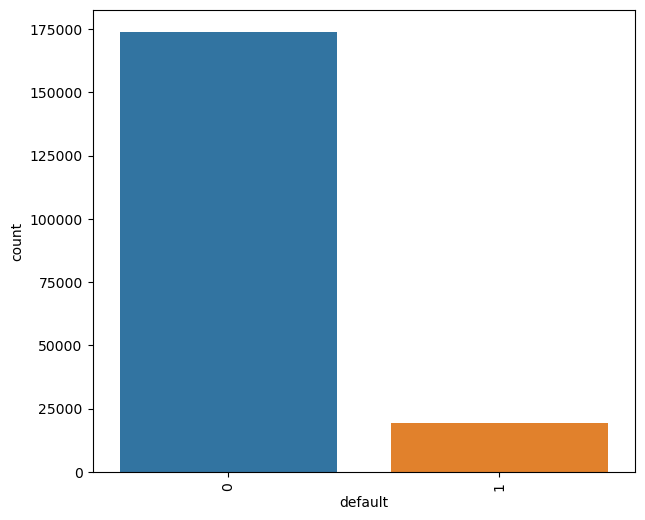

Класс 0: 173948 || Класс 1: 19226
Отношение классов  11.05%


In [10]:
# распределение таргета

plt.figure(figsize=(7, 6))
sns.countplot(x='default', data=df)
plt.xticks(rotation=90)
plt.show()

print(
    f'Класс 0: {df.default.value_counts()[0]} || Класс 1: {df.default.value_counts()[1]}')
print(
    f'Отношение классов {df.default.value_counts()[1]/df.default.value_counts()[0]*100: .2f}%')

In [11]:
# temp1 = pd.DataFrame(df.groupby(['bureau_cd', 'type',])['credit_limit'].mean()) \
#             .rename(columns={'credit_limit': 'bureau_cd_type_mean_credit_limit'})

# temp2 = pd.DataFrame(df.groupby(['bureau_cd', 'type',])['credit_limit'].median()) \
#             .rename(columns={'credit_limit': 'bureau_cd_type_median_credit_limit'})

# temp3 = pd.DataFrame(df.groupby(['type', 'status'])['credit_limit'].mean()) \
#             .rename(columns={'credit_limit': 'bureau_cd_type_median_credit_limit2'})

# temp4 = pd.DataFrame(df.groupby(['bureau_cd', 'status'])['credit_limit'].median()) \
#             .rename(columns={'credit_limit': 'bureau_cd_type_median_credit_limit3'})

In [1]:
# df.columns

In [2]:
# df = df.merge(temp1, how='left', on=['bureau_cd', 'type'])
# df = df.merge(temp2, how='left', on=['bureau_cd', 'type'])
# df = df.merge(temp3, how='left', on=['type', 'status'])
# df = df.merge(temp4, how='left', on=['bureau_cd', 'status'])
# df

## 1.3 Выбросы

In [14]:
from scipy.special import boxcox1p
# + Box-Cox

def outliers(col):
    Q25 = np.quantile(col, .25)
    Q75 = np.quantile(col, .75)
    IQR = Q75 - Q25
    return np.where((col < (Q25 - IQR * 1.5)) | (col > (Q75 + IQR * 1.5)), col.mean(), col)


# применим функцию, которая заменяет значения в колонке на среднее,
# если они больше 75 квантиля или меньше 25 (то есть выбросы)
for col in ['credit_limit', 'max_delq_balance', 'interest_rate']:
    df[col] = boxcox1p(df[col], 0.15)
    df[col] = outliers(df[col])

In [15]:
import copy

data_clean = copy.deepcopy(df)

## 1.4 Выбор признаков

In [16]:
# Обучим модель, чтобы потом определить количество признаков

y = data_clean.default
x = data_clean.drop('default', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25)


log = Pipeline(steps=[('sc', MinMaxScaler()),
                      ('sl', SelectKBest(score_func=f_classif, k=2)),
                      ('model', LogisticRegression())])

log.fit(x_train, y_train)

Pipeline(steps=[('sc', MinMaxScaler()), ('sl', SelectKBest(k=2)),
                ('model', LogisticRegression())])

In [17]:
%%time

'Определим переменные, которые сильнее всего влияют на default и их оптимальное количество'

param_grid = {'sl__k': np.arange(2, len(data_clean.columns), 1)}

search_log = GridSearchCV(log,
                          param_grid,
                          cv=3,
                          n_jobs=-1,
                          scoring='roc_auc',
                          refit=True,
                          verbose=10)


search_log.fit(x_train, y_train)

print()
print(f'Оптимальное количество параметров - {search_log.best_estimator_[1]}')
print()

Fitting 3 folds for each of 29 candidates, totalling 87 fits

Оптимальное количество параметров - SelectKBest(k=29)

CPU times: total: 5.81 s
Wall time: 20 s


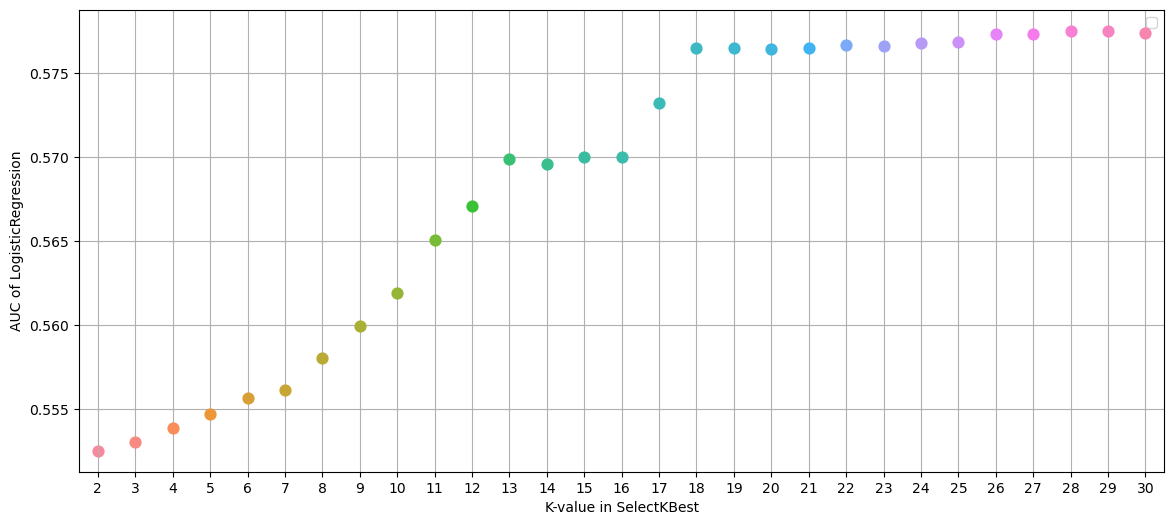

In [18]:
# график точности от количества выбранных факторов
plt.subplots(figsize=(14, 6))

sns.pointplot(x=search_log.cv_results_['param_sl__k'],
              y=search_log.cv_results_['mean_test_score'],
              hue=search_log.cv_results_['param_sl__k'])

plt.legend(np.arange(2, len(data_clean.columns), 2), 'upper')
plt.xlabel('K-value in SelectKBest')
plt.ylabel('AUC of LogisticRegression')
plt.grid(True)
plt.show()

In [19]:
# выбираем оптимальное количество колонок
select = SelectKBest(score_func=f_classif, k=18)
best = select.fit_transform(x, y)

columns_imp = x.columns[select.get_support()].to_list()
columns_imp

['bureau_cd',
 'type',
 'status',
 'credit_limit',
 'ttl_delq_5',
 'ttl_delq_30',
 'ttl_delq_60_89',
 'ttl_delq_90_plus',
 'max_delq_balance',
 'interest_rate',
 'relationship',
 'bki_request_date_day',
 'bki_request_date_dayWeek',
 'open_date_month',
 'bureau_cd_type_mean_credit_limit',
 'bureau_cd_type_median_credit_limit',
 'bureau_cd_type_median_credit_limit2',
 'bureau_cd_type_median_credit_limit3']

In [20]:
# нормируем данные

for ind, val in enumerate(data_clean[columns_imp]):
    data_clean[val] = np.log1p(data_clean[val])

# 2. AutoML

In [ ]:
# !pip uninstall scikit-learn -y
# !pip uninstall numpy -y
# !pip install scikit-learn==0.23.2
# !pip install numpy==1.20
# !pip install pycaret

# import pycaret
# from pycaret.classification import *
# from pycaret.utils import enable_colab
# enable_colab()

In [ ]:
# import h2o
# from h2o.automl import H2OAutoML

In [4]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [23]:
x_y_train = x_train
x_y_train['default'] = y_train
x_y_train.head()
# соединяем x_train и y_train - модель ожидает такой формат входных данных

,bureau_cd,type,status,credit_limit,ttl_delq_5,ttl_delq_30,ttl_delq_60_89,ttl_delq_90_plus,max_delq_balance,interest_rate,relationship,bki_request_date_day,bki_request_date_dayWeek,open_date_month,default
17097,0.693147,4.605170,2.639057,8.790878,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,2.639057,1.945910,1.945910,0
123623,1.386294,2.302585,2.639057,8.651724,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,2.397895,0.000000,1.945910,0
122449,1.386294,2.302585,2.639057,10.819798,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,3.465736,1.609438,2.484907,0
296018,0.693147,4.605170,0.000000,8.599063,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,2.830181,1.791759,2.475788,1
97118,1.386294,2.302585,0.000000,10.819798,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,1.386294,0.693147,0.693147,0


In [24]:
# настройка модели

roles = {
    'target': 'default',
}

automl = TabularAutoML(
    task=Task('binary', metric='auc'),
    timeout=60*3,
    cpu_limit=6,
    reader_params={'n_jobs': 6, 'cv': 5, 'random_state': 101},
    general_params={'use_algos': [['linear_l2', 'lgb', 'cb', 'lgb_tuned']]},
)

rd = ReportDeco('TabReport2')
automl_rd = rd(automl)

models = automl_rd.fit_predict(x_y_train, roles=roles, verbose=1)

[10:43:03] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[10:43:03] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[10:43:03] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[10:43:03] - time: 180.00 seconds


INFO:lightautoml.automl.presets.base:- time: 180.00 seconds


[10:43:03] - CPU: 6 cores


INFO:lightautoml.automl.presets.base:- CPU: 6 cores


[10:43:03] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[10:43:03] Train data shape: (243435, 15)



INFO:lightautoml.reader.base:Train data shape: (243435, 15)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[10:43:09] Layer 1 train process start. Time left 173.47 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 173.47 secs


[10:43:31] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 31}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.9411972491496509
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.9429565842121962
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.9436581557548612
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.9444904904032763
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.9446219580243462
INFO3:lightautoml.m

[10:44:05] Time limit exceeded after calculating fold 3



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 3



[10:44:05] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9452453238487784


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9452453238487784


[10:44:05] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[10:44:05] Time left 117.52 secs



INFO:lightautoml.automl.base:Time left 117.52 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.95556
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.96077
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.962825
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.96445
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.965475
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.966194
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.96685
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.967366
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.967733
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.968003
DEBUG:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.968158
DEBUG:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.968378
DEBUG:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.968546
DEBU

[10:46:57] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[10:47:22] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.04, 'num_leaves': 128, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 2000, 'early_stopping_rounds': 100, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.964081
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.965589
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.966497
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.966889
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	v

[10:49:45] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[10:49:45] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9691739465233082


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9691739465233082


[10:49:45] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[10:49:45] Time left -222.57 secs



INFO:lightautoml.automl.base:Time left -222.57 secs



[10:49:45] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[10:49:45] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[10:49:46] Blending: optimization starts with equal weights and score 0.9520622793124547


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.9520622793124547


[10:49:47] Blending: iteration 0: score = 0.9524835876999693, weights = [0.17751677 0.82248324]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.9524835876999693, weights = [0.17751677 0.82248324]


[10:49:48] Blending: iteration 1: score = 0.9524835876999693, weights = [0.17751677 0.82248324]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.9524835876999693, weights = [0.17751677 0.82248324]


[10:49:48] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[10:49:48] Automl preset training completed in 404.74 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 404.74 seconds



[10:49:48] Model description:
Final prediction for new objects (level 0) = 
	 0.17752 * (4 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.82248 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.17752 * (4 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.82248 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



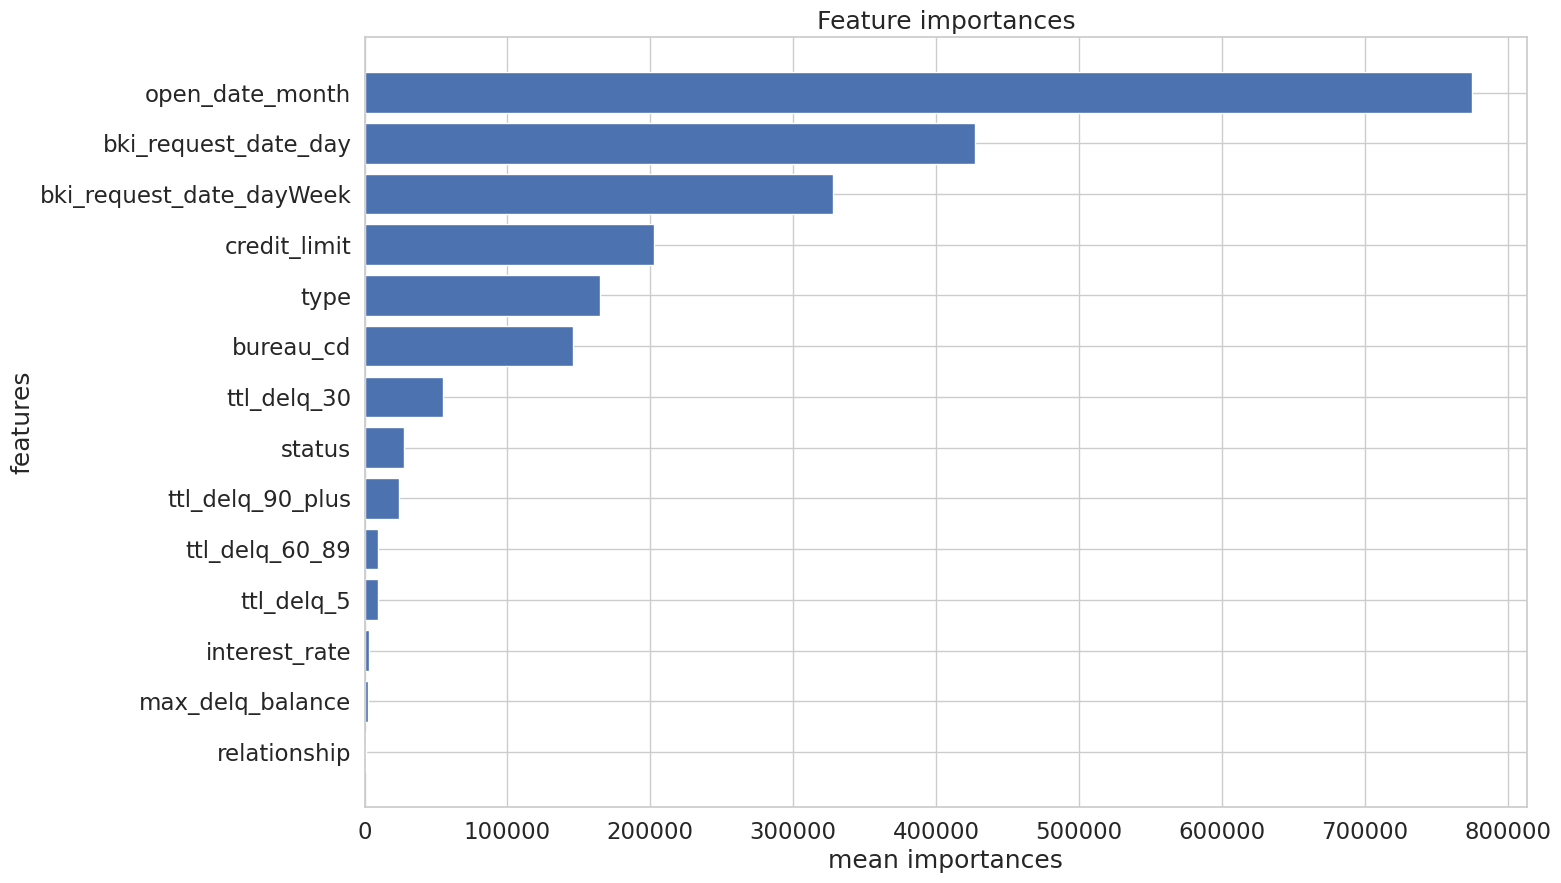

In [60]:
plt.figure(figsize=(15, 10))
plt.barh(imps.index, imps.Importance)
plt.title('Feature importances')
plt.xlabel('mean importances')
plt.ylabel('features')
plt.show()

In [62]:
feat_imp = imps.sort_values('Importance', ascending=False)
feat_imp['Description'] = [desc_param.get(
    param.upper()) for param in feat_imp.index]
feat_imp

,Importance,Description
Feature,,
open_date_month,774910.712420,месяц открытия договора
bki_request_date_day,427034.787121,"день, в который был сделан запрос в бюро"
bki_request_date_dayWeek,328004.809811,"день недели, в который был сделан запрос в бюро"
credit_limit,202398.403699,Кредитный лимит. Сумма в рублях по курсу ЦБ РФ
type,164647.945210,Код типа договора
bureau_cd,145699.702736,"Код бюро, из которого получен счет"
ttl_delq_30,54763.026632,Количество просрочек до 30 дней
status,27578.558145,Статус договора
ttl_delq_90_plus,24093.585213,Количество просрочек 90+ дней


In [66]:
preds = automl.predict(x_test)

print(f'AUC score on test: {roc_auc_score(y_test.values, preds.data[:, 0])}')
print(
    f'GINI score on test: {roc_auc_score(y_test.values, preds.data[:, 0])*2-1}')

AUC score on test: 0.9687273522879267
GINI score on test: 0.9374547045758534


In [17]:
# финальная модель automl
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.17752 * (4 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.82248 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM)


In [34]:
# Auto ML дала хорошие результаты, использовала Ridge Regression,
# но с маленьким весом - 0.177, также занизила важность
# и оставила 6 признаков (из 14)

# 3. Модели

In [71]:
# функция для оценки моделей

def get_report(pipe, x_test, y_test):

    predictions = pipe.predict(x_test)
    predictions = np.round(predictions.ravel(), 0)

    roc_auc_scores_pipe = roc_auc_score(
        y_test, pipe.predict_proba(x_test)[:, 1])
    gini = (2 * roc_auc_scores_pipe) - 1

    print('y_test - ', Counter(y_test))
    print('predictions - ', Counter(predictions))
    print()
    print(f'roc_auc_score - {round(roc_auc_scores_pipe, 4)}')
    print('Gini - ', round(gini, 4))
    print()
    print((classification_report(y_test, predictions)))

In [51]:
from imblearn.over_sampling import SMOTE

%%time

data_clean = data_clean[columns_imp+['default']]
data_clean.dropna(axis=0, inplace=True)
data_clean.drop_duplicates(inplace=True)

y = data_clean.default
x = data_clean.drop('default', axis=1)


# для улучшения качества моделей применим метод SMOTETomek,
# который создает новые строки с таргетом 1 (у нас соотношение 1 к 9)
imbalance = SMOTETomek(sampling_strategy='auto', n_jobs=6)
x_imb, y_imb = imbalance.fit_resample(x, y)


x_imb.shape, y_imb.shape

CPU times: total: 3min 46s
Wall time: 43.9 s


((324476, 14), (324476,))

In [180]:
print(
    'Количесво классов после SMOTETomek:', Counter(y_imb)
)

Количесво классов после SMOTETomek: Counter({0: 162238, 1: 162238})


In [52]:
# делим выборку на train/ test
x_train, x_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, test_size=0.25, )

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((243357, 14), (243357,), (81119, 14), (81119,))

In [53]:
# делим выборку на test/ validation
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, stratify=y_test, test_size=0.1)

x_test.shape, y_test.shape, x_val.shape, y_val.shape

((73007, 14), (73007,), (8112, 14), (8112,))

### 0. Stacked models 

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, ClassifierMixin, clone
from sklearn.neural_network import MLPClassifier

In [22]:
data_clean = data_clean[columns_imp + ['default']]
data_clean.dropna(axis=0, inplace=True)
data_clean.drop_duplicates(inplace=True)

y = data_clean.default
x = data_clean.drop('default', axis=1)


# делим выборку на train/ test/ val
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25)

# imbalance = NearMiss(sampling_strategy='auto', n_jobs=6)
# imbalance = SMOTETomek(sampling_strategy='auto', n_jobs=6)
# x_train, y_train = imbalance.fit_resample(x_train, y_train)


x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, stratify=y_test, test_size=0.1)

(x_train.shape, y_train.shape), (x_test.shape, y_test.shape), (x_val.shape, y_val.shape)

(((141693, 18), (141693,)), ((42507, 18), (42507,)), ((4724, 18), (4724,)))

In [23]:
Counter(y_train), Counter(y_test), Counter(y_val)

(Counter({0: 127382, 1: 14311}),
 Counter({0: 38214, 1: 4293}),
 Counter({0: 4247, 1: 477}))

In [47]:
data_clean.head()

,bureau_cd,type,status,credit_limit,ttl_delq_5,ttl_delq_30,ttl_delq_60_89,ttl_delq_90_plus,max_delq_balance,interest_rate,relationship,bki_request_date_day,bki_request_date_dayWeek,open_date_month,bureau_cd_type_mean_credit_limit,bureau_cd_type_median_credit_limit,bureau_cd_type_median_credit_limit2,bureau_cd_type_median_credit_limit3,default
0,0.693147,2.302585,2.639057,2.984633,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,1.098612,0.0,2.397895,10.675124,9.615872,10.542336,9.288319,0
1,1.386294,2.302585,0.000000,3.179620,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,1.098612,0.0,1.609438,11.066263,10.081885,11.472293,10.596660,0
2,1.386294,2.302585,2.639057,2.984633,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,1.098612,0.0,2.397895,11.066263,10.081885,10.542336,9.752781,0
3,1.098612,2.079442,0.000000,3.168931,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,1.609438,0.0,1.386294,10.527272,9.903538,10.580563,10.596660,1
4,0.693147,2.302585,2.639057,3.192350,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,1.609438,0.0,2.079442,10.675124,9.615872,10.542336,9.288319,1


In [24]:
# rfc.fit(x_train.values, y_train.values)
# print(roc_auc_score(y_test, rfc.predict_proba(x_test)[:, 1]))


# importances222 = rfc[-1].feature_importances_

# forest_importances222 = pd.Series(
#     importances, index=x_train.columns).sort_values(0, ascending=True)[:25]

# fig, ax = plt.subplots(figsize=(15, 6))
# forest_importances222.plot.barh(ax=ax)
# ax.set_title('Feature importances')
# ax.set_ylabel('mean importances')
# plt.show()

In [85]:
# import shap

# explainer = shap.LinearExplainer(rfc[-1], x_train, feature_dependence='independent')
# shap_values = explainer(x_test)

In [25]:
class CV_test():
    ''' кросс-валидация '''
    def __init__(self, n_folds: int = 3):
        self.n_folds = n_folds
        
    def cross_val_test(self, model: 'estimator', x: list, y: list):
        kf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        scores = cross_val_score(estimator=model, 
                                 X=x,
                                 y=y,
                                 cv=kf,
                                 scoring='roc_auc',
                                 verbose=0,
                                 n_jobs=-1)
    
        return scores

In [26]:
# инициализируем  модели 

logreg = make_pipeline(RobustScaler(),
                       LogisticRegression(verbose=0))

rfc = make_pipeline(RobustScaler(), 
                    RandomForestClassifier(
                        verbose=0,
                        n_jobs=-1,
                        criterion='gini',
                        n_estimators=100,
#                         max_depth=12,
#                         min_samples_leaf=12,
#                         max_samples=100,
                        class_weight='balanced_subsample'
                    ))


lgb = make_pipeline(RobustScaler(), 
                    LGBMClassifier(
                        n_estimators=500,
#                         max_depth=12,
#                         learning_rate=0.0708,
# #                         num_leaves=24,
#                         reg_alpha=0.05,
                        reg_lambda=12, 
                        n_jobs=-1,
                        verbose=1,
                    ))


xgb = make_pipeline(RobustScaler(), 
                    XGBClassifier(
                       tree_method='gpu_hist',
                       objective='binary:logistic',
#                        learning_rate=0.05,
                       n_estimators=500,
#                        reg_lambda=12,
#                        max_depth=12,
                    ))


mlp = make_pipeline(RobustScaler(),
                    MLPClassifier(
                        activation='relu',
                        solver='adam',
                        learning_rate_init=3e-5,
                        learning_rate='adaptive',
                        batch_size=256,
                        max_iter=100,
                        alpha=1e-5,
                        early_stopping=True,
                        hidden_layer_sizes=(500, 1)
                    ))

In [75]:
CV_class = CV_test(n_folds=3)

scores = CV_class.cross_val_test(model=rfc, x=x_train, y=y_train)
scores.mean()

0.5271617221989523

In [27]:
class StackingAveragedModels(BaseEstimator, TransformerMixin, ClassifierMixin):
    '''
    class for stacking models
    '''
    def __init__(self, base_models, meta_model, n_folds=3):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   

    def fit(self, x_train, y_train):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        out_of_fold_predictions = np.zeros((x_train.shape[0], len(self.base_models)))
        
        for i, model in tqdm_notebook(enumerate(self.base_models)):
            print(f'Process: fit model Num {i}')
            for train_index, holdout_index in kfold.split(x_train, y_train):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(x_train[train_index], y_train[train_index])
                y_pred = instance.predict_proba(x_train[holdout_index])[:, 1]
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y_train)
        
        return self
   

    def predict(self, x_test):
        print('Process: predict')
        meta_preds = [np.column_stack([model.predict_proba(x_test)[:, 1] for model in base_models]).mean(axis=1) for base_models in self.base_models_]
        meta_features = np.column_stack(meta_preds)
        
        return self.meta_model_.predict_proba(meta_features)[:, 1]

In [143]:
stacked_avg_models = StackingAveragedModels(base_models=(rfc, lgb, xgb), 
                                            meta_model=logreg)

score = cross_val_test(stacked_avg_models)
print(f'MEAN ROC_AUC BY CROSS VAL SCORE: {score.mean():.4f} (+-{score.std():.5f})')

MEAN ROC_AUC BY CROSS VAL SCORE: 0.6560 (+-0.00251)


In [28]:
%%time
stacked_avg_models = StackingAveragedModels(base_models=(rfc, lgb, xgb), 
                                            meta_model=xgb)

stacked_avg_models.fit(x_train.values, y_train.values)
stacked_pred = stacked_avg_models.predict(x_test.values)

roc_auc_score(y_test, stacked_pred)

0it [00:00, ?it/s]

Process: fit model Num 0
Process: fit model Num 1
Process: fit model Num 2
Process: predict
CPU times: total: 1min 39s
Wall time: 24.8 s


0.6272687876850697

In [66]:
model_dict = {}

for name, model in zip(['rfc', 'lgb', 'xgb'], [rfc, lgb, xgb]):
    model.fit(x_train.values, y_train.values)
    model_dict[f'{name}_pred'] = model.predict_proba(x_test.values)[:, 1]
    print(f'ROC AUC OF {name}: {roc_auc_score(y_test, model_dict.get(f"{name}_pred")):.5f}')

ROC AUC OF rfc: 0.51194
ROC AUC OF lgb: 0.62363
ROC AUC OF xgb: 0.62070


In [29]:
rfc.fit(x_train.values, y_train.values)
rfc_pred = rfc.predict_proba(x_test.values)[:, 1]
print(f'ROC AUC OF rfc_pred: {roc_auc_score(y_test, rfc_pred):.5f}')

lgb.fit(x_train.values, y_train.values)
lgb_pred = lgb.predict_proba(x_test.values)[:, 1]
print(f'ROC AUC OF lgb: {roc_auc_score(y_test, lgb_pred):.5f}')

xgb.fit(x_train.values, y_train.values)
xgb_pred = xgb.predict_proba(x_test.values)[:, 1]
print(f'ROC AUC OF xgb: {roc_auc_score(y_test, xgb_pred):.5f}')

ROC AUC OF rfc_pred: 0.59058
ROC AUC OF lgb: 0.65641
ROC AUC OF xgb: 0.67259


In [58]:
model_dict

{'rfc_pred': array([0.02, 0.1 , 0.04, ..., 0.05, 0.14, 0.03]),
 'lgb_pred': array([0.03101518, 0.11477713, 0.03255407, ..., 0.1534778 , 0.07562254,
        0.01021438]),
 'xgb_pred': array([1.3326402e-02, 7.1974553e-02, 1.2512793e-04, ..., 5.9897080e-02,
        1.4718468e-03, 3.3062952e-07], dtype=float32)}

In [31]:
# ensemble_df = pd.DataFrame(model_dict)
ensemble_df = pd.DataFrame({'rfc_pred':rfc_pred, 'lgb_pred':lgb_pred, 'xgb_pred':xgb_pred})
rfc_pred = ensemble_df.rfc_pred
lgb_pred = ensemble_df.lgb_pred
xgb_pred = ensemble_df.xgb_pred

best_auc = []

ens = (0.55 * stacked_pred) + (0.15 * rfc_pred) + (0.15 * lgb_pred) + (0.15 * xgb_pred)
auc = roc_auc_score(y_test, ens)
best_auc.append(auc)


for i in tqdm_notebook(range(100)):
    weight = np.random.dirichlet([1, 1, 1, 1])
    ens = (weight[0] * stacked_pred) + (weight[1] * rfc_pred) + (weight[2] * lgb_pred) + (weight[3] * xgb_pred)
    
    auc = roc_auc_score(y_test, ens)
    best_auc.append(auc)
    
    if best_auc[-1] >= max(best_auc):
        best_weights = weight


        
# ensemble_df = pd.DataFrame(model_dict)

ensemble_df['ensemble'] = (best_weights[0] * stacked_pred) + (best_weights[1] * rfc_pred) + (best_weights[2] * lgb_pred) + (best_weights[3] * xgb_pred) 
ensemble_df['y_test'] = y_test.values


print(f'RFC ROC AUC: {roc_auc_score(y_test, ensemble_df.rfc_pred):.5f}')
print(f'LGB ROC AUC: {roc_auc_score(y_test, ensemble_df.lgb_pred):.5f}')
print(f'XGB ROC AUC: {roc_auc_score(y_test, ensemble_df.xgb_pred):.5f}')
print(f'MEAN WEIGHT STACKED ROC AUC: {roc_auc_score(y_test, np.mean([stacked_pred, rfc_pred, lgb_pred, xgb_pred], axis=0)):.5f}')
print()
print(f'BEST WEIGHTS ARE: {best_weights}')
print(f'BEST WEIGHTS STACKED ROC AUC: {roc_auc_score(y_test, ensemble_df.ensemble):.5f}')

ensemble_df.head(10)

  0%|          | 0/100 [00:00<?, ?it/s]

RFC ROC AUC: 0.59058
LGB ROC AUC: 0.65641
XGB ROC AUC: 0.67259
MEAN WEIGHT STACKED ROC AUC: 0.66248

BEST WEIGHTS ARE: [0.01520708 0.01332545 0.43229359 0.53917388]
BEST WEIGHTS STACKED ROC AUC: 0.67802


,rfc_pred,lgb_pred,xgb_pred,ensemble,y_test
0,0.030000,0.086446,0.079608,0.082574,0
1,0.050000,0.076115,0.012183,0.040880,0
2,0.080000,0.045654,0.000279,0.021793,0
3,0.000000,0.046531,0.054389,0.049983,0
4,0.120000,0.128135,0.091470,0.108983,0
5,0.080000,0.116485,0.160508,0.139686,1
6,0.120000,0.098299,0.079377,0.088561,0
7,0.000000,0.057351,0.035296,0.044274,0
8,0.270000,0.223865,0.411477,0.327811,1
9,0.663559,0.128621,0.120415,0.129718,0


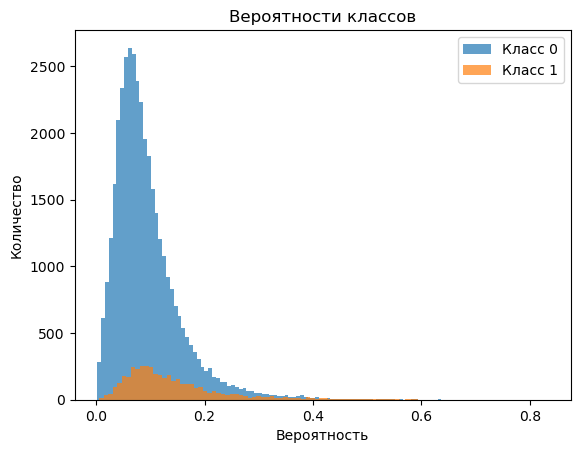

In [32]:
plt.hist(ensemble_df[ensemble_df['y_test'] == 0].ensemble, bins=100, alpha=0.7, label='Класс 0')
plt.hist(ensemble_df[ensemble_df['y_test'] == 1].ensemble, bins=100, alpha=0.7, label='Класс 1')
plt.title('Вероятности классов')
plt.xlabel('Вероятность')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [37]:
rfc_pred_val = rfc.predict_proba(x_val.values)[:, 1]
print(f'ROC AUC OF rfc_pred: {roc_auc_score(y_val, rfc_pred_val):.5f}')

lgb_pred_val = lgb.predict_proba(x_val.values)[:, 1]
print(f'ROC AUC OF lgb: {roc_auc_score(y_val, lgb_pred_val):.5f}')

xgb_pred_val = xgb.predict_proba(x_val.values)[:, 1]
print(f'ROC AUC OF xgb: {roc_auc_score(y_val, xgb_pred_val):.5f}')

stacked_pred_val = stacked_avg_models.predict(x_val.values)

roc_auc_score(y_val, stacked_pred_val)

ROC AUC OF rfc_pred: 0.57422
ROC AUC OF lgb: 0.66121
ROC AUC OF xgb: 0.67531
Process: predict


0.6080232241873534

In [38]:
ensemble_val = (best_weights[0] * stacked_pred_val) + \
               (best_weights[1] * rfc_pred_val)     + \
               (best_weights[2] * lgb_pred_val)     + \
               (best_weights[3] * xgb_pred_val)

roc_auc_score(y_val, ensemble_val)

0.6787958351659256

## 3.1 LogisticRegression

In [ ]:
# для улучшения показателей линейной модели, признаки должны быть линейно зависимы с таргетом
# выделим наиболее значимые признаки с помощью корреляции

In [74]:
corr = pd.concat([x_train, y_train], axis=1).corr()

<Axes: >

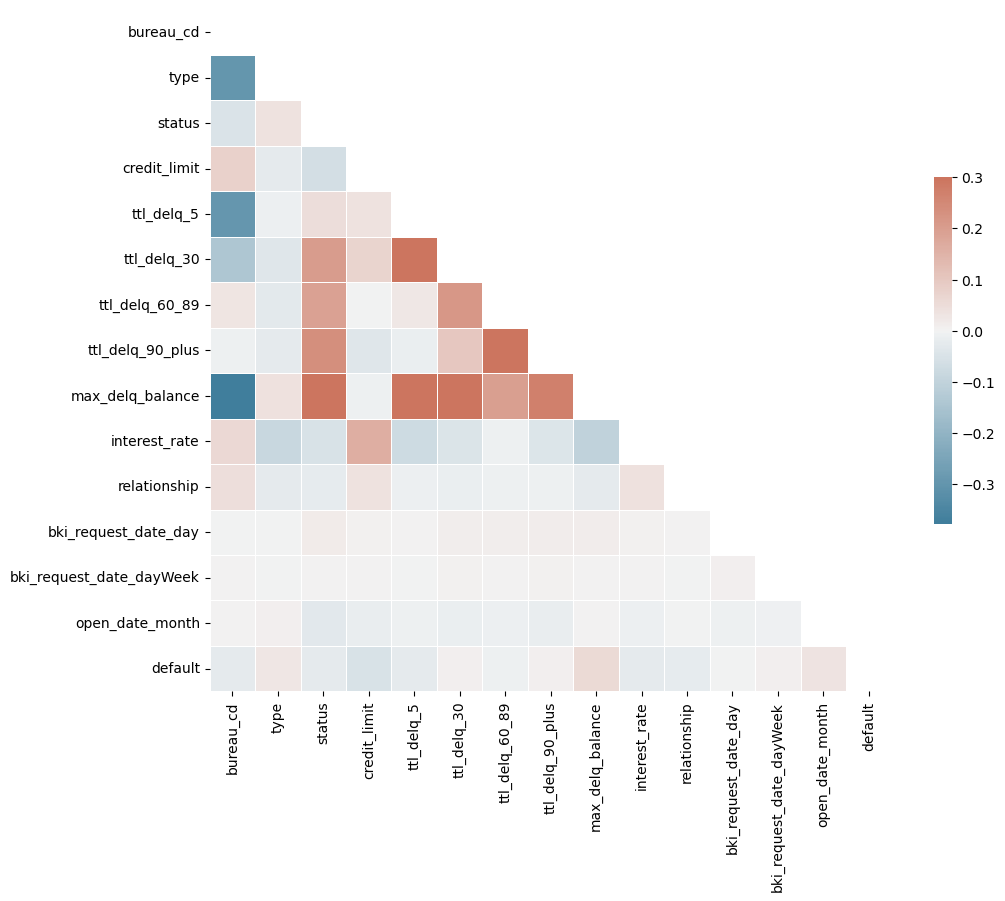

In [75]:
corr = pd.concat([x_train, y_train], axis=1).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})

In [92]:
max_iter = range(100, 300, 50)
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
C = np.arange(0, 1, 0.1)

random_grid = {
    'model__max_iter': max_iter,
    'model__warm_start': warm_start,
    'model__solver': solver,
    'model__C': C,
}


estimator = Pipeline(steps=[('sc', MinMaxScaler()),
                            ('model', LogisticRegression())])

random_estimator = RandomizedSearchCV(estimator=estimator,
                                      param_distributions=random_grid,
                                      n_iter=20,
                                      scoring='f1',
                                      n_jobs=-1,
                                      verbose=1,
                                      random_state=1881,
                                      )

random_estimator.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('sc', MinMaxScaler()),
                                             ('model', LogisticRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'model__max_iter': range(100, 300, 50),
                                        'model__solver': ['lbfgs', 'newton-cg',
                                                          'liblinear'],
                                        'model__warm_start': [True, False]},
                   random_state=1881, scoring='f1', verbose=1)

In [93]:
print(random_estimator.best_params_, '\n')

best_estimator = random_estimator.best_estimator_
best_estimator.fit(x_train, y_train)

get_report(pipe=best_estimator, x_test=x_test, y_test=y_test)
print()

{'model__warm_start': False, 'model__solver': 'lbfgs', 'model__max_iter': 200, 'model__C': 0.4} 

y_test -  Counter({1: 36504, 0: 36503})
predictions -  Counter({0: 39525, 1: 33482})

roc_auc_score - 0.5793
Gini -  0.1586

              precision    recall  f1-score   support

           0       0.55      0.60      0.58     36503
           1       0.56      0.52      0.54     36504

    accuracy                           0.56     73007
   macro avg       0.56      0.56      0.56     73007
weighted avg       0.56      0.56      0.56     73007




Text(0, 0.5, 'Mean importance')

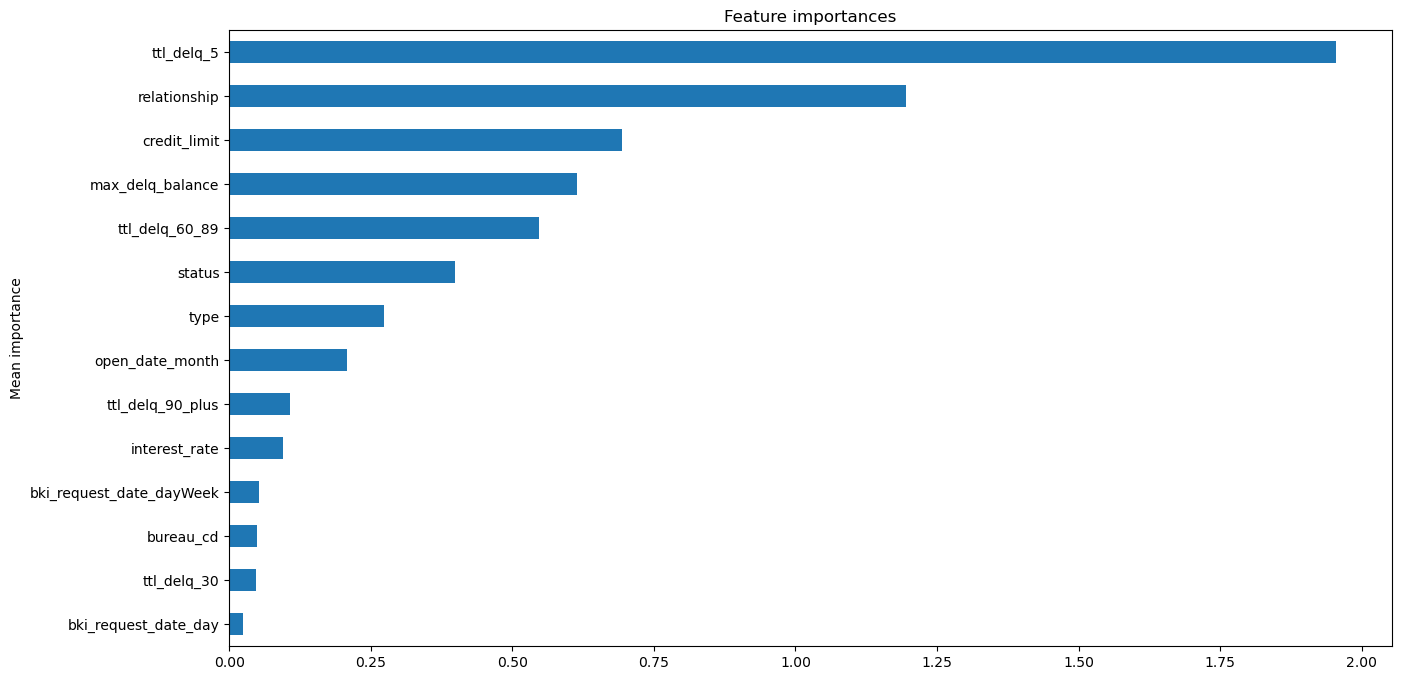

In [95]:
# plt.style.use('tableau-colorblind10')
log_importances = pd.Series(abs(pipe_logreg[-1].coef_[0]),
                            index=x_train.columns).sort_values(0, ascending=True)[:25]

fig, ax = plt.subplots(figsize=(15, 8))
log_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean importance')

In [96]:
feat_imp = pd.DataFrame(log_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(
    param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
ttl_delq_5,1.955035,Количество просрочек до 5 дней
relationship,1.194504,Тип отношения к договору
credit_limit,0.694176,Кредитный лимит. Сумма в рублях по курсу ЦБ РФ
max_delq_balance,0.615096,Максимальный объем просроченной задолженности....
ttl_delq_60_89,0.547859,Количество просрочек от 60 до 89 дней
status,0.398073,Статус договора
type,0.274258,Код типа договора
open_date_month,0.208038,месяц открытия договора
ttl_delq_90_plus,0.107665,Количество просрочек 90+ дней
interest_rate,0.095356,Процентная ставка по кредиту


In [ ]:
# в обучающей выборке нет коррелируемых с таргетом признаков, это значит,
# что модель не сможет достичь наилучшего качества

## 3.2 LinearRegression

In [98]:
pipe_linreg = Pipeline(steps=[('scaler', MinMaxScaler()),
                              ('logistic', LinearRegression(positive=True,
                                                            fit_intercept=True))])

pipe_linreg.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LinearRegression(positive=True))])

In [101]:
predictions = pipe_linreg.predict(x_test)
predictions = np.round(predictions.ravel(), 0)
diff = predictions - y_test

print('MSE:', np.mean(diff**2))
print('MAE:', np.mean(abs(diff)))
print('RMSE:', np.sqrt(np.mean(diff**2)))
print()

get_report(pipe=pipe_logreg, x_test=x_test, y_test=y_test)
print()

MSE: 0.472379360883203
MAE: 0.472379360883203
RMSE: 0.6872985965962705

y_test -  Counter({1: 36504, 0: 36503})
predictions -  Counter({0: 39522, 1: 33485})

roc_auc_score - 0.5793
Gini -  0.1587

              precision    recall  f1-score   support

           0       0.55      0.60      0.58     36503
           1       0.56      0.52      0.54     36504

    accuracy                           0.56     73007
   macro avg       0.56      0.56      0.56     73007
weighted avg       0.56      0.56      0.56     73007




Text(0, 0.5, 'mean importance')

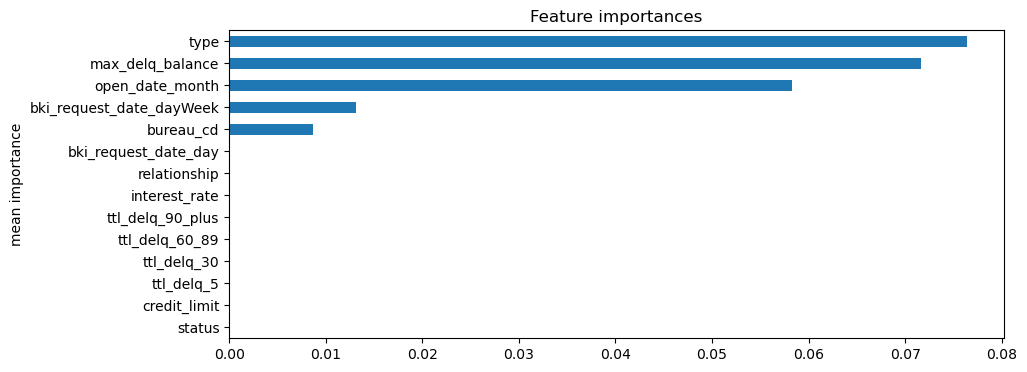

In [104]:
# plt.style.use('tableau-colorblind10')
log_importances = pd.Series(abs(pipe_linreg[-1].coef_), index=x_test.columns) \
    .sort_values(0, ascending=True)

fig, ax = plt.subplots(figsize=(10, 4))
log_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importance')

In [105]:
feat_imp = pd.DataFrame(log_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(
    param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
type,0.076423,Код типа договора
max_delq_balance,0.071588,Максимальный объем просроченной задолженности....
open_date_month,0.058250,месяц открытия договора
bki_request_date_dayWeek,0.013121,"день недели, в который был сделан запрос в бюро"
bureau_cd,0.008719,"Код бюро, из которого получен счет"
status,0.000000,Статус договора
credit_limit,0.000000,Кредитный лимит. Сумма в рублях по курсу ЦБ РФ
ttl_delq_5,0.000000,Количество просрочек до 5 дней
ttl_delq_30,0.000000,Количество просрочек до 30 дней
ttl_delq_60_89,0.000000,Количество просрочек от 60 до 89 дней


In [ ]:
# Аналогично c LinearRegression

# Если оценивать результаты по MSE или MAE, то ошибка очень большая
# при выборе 0 или 1, ошибка состовляет +-0.47 - очень много

# Для улучшения нужны коррелируемые с таргетом признаки

## 3.3 RandomForestClassifier

In [ ]:
# from imblearn.ensemble import BalancedRandomForestClassifier

In [69]:
pipe_rforest = Pipeline(steps=[
    ('m', RandomForestClassifier(verbose=1,
                                 n_jobs=-1,
                                 criterion='gini',
                                 n_estimators=100,
                                 #                                          max_depth=12,
                                 #  min_samples_leaf=6,
                                 #  max_samples=500,
                                 #  class_weight={0: 1, 1: 10},
                                 class_weight='balanced_subsample'
                                 ))
])

pipe_rforest.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


Pipeline(steps=[('m',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_jobs=-1, verbose=1))])

In [55]:
get_report(pipe=pipe_rforest, x_test=x_test, y_test=y_test)
print()

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


y_test -  Counter({1: 36504, 0: 36503})
predictions -  Counter({0: 38851, 1: 34156})

roc_auc_score - 0.9734
Gini -  0.9468

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     36503
           1       0.96      0.90      0.93     36504

    accuracy                           0.93     73007
   macro avg       0.93      0.93      0.93     73007
weighted avg       0.93      0.93      0.93     73007




[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.3s finished


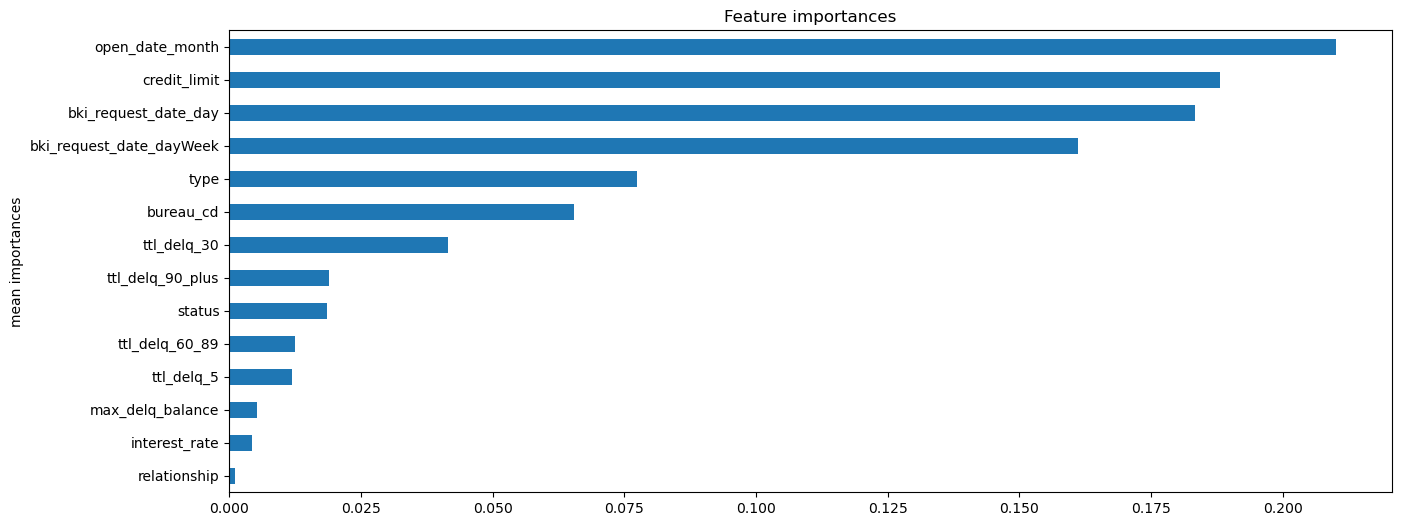

In [56]:
importances = pipe_rforest[-1].feature_importances_

forest_importances = pd.Series(
    importances, index=x_train.columns).sort_values(0, ascending=True)[:25]

fig, ax = plt.subplots(figsize=(15, 6))
forest_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importances')
plt.show()

In [57]:
feat_imp = pd.DataFrame(forest_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(
    param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
open_date_month,0.210132,месяц открытия договора
credit_limit,0.187994,Кредитный лимит. Сумма в рублях по курсу ЦБ РФ
bki_request_date_day,0.183318,"день, в который был сделан запрос в бюро"
bki_request_date_dayWeek,0.161200,"день недели, в который был сделан запрос в бюро"
type,0.077463,Код типа договора
bureau_cd,0.065517,"Код бюро, из которого получен счет"
ttl_delq_30,0.041581,Количество просрочек до 30 дней
ttl_delq_90_plus,0.019043,Количество просрочек 90+ дней
status,0.018609,Статус договора
ttl_delq_60_89,0.012455,Количество просрочек от 60 до 89 дней


In [123]:
% % time
cv_pipe_rforest = cross_val_predict(pipe_rforest,
                                    cv=StratifiedKFold(
                                        n_splits=5, shuffle=True, random_state=42),
                                    X=x_test,
                                    y=y_test,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.3s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished


CPU times: total: 93.8 ms
Wall time: 16 s


In [124]:
print(f'auc score = {roc_auc_score(y_test, cv_pipe_rforest[:, 1]):.5f}')
print(
    f'Gini      = { (2 * roc_auc_score(y_test, cv_pipe_rforest[:, 1]) - 1) :.5f}')

auc score = 0.96338
Gini      = 0.92676


In [ ]:
# модель RandomForestClassifier показала высокие результаты по AUC - 0.9734,
# оценка через кросс-валидацию составила 0.96338

# Высокий результат

## 3.4 LGBMClassifier

In [ ]:
# при помощи optuna посмотрим, можно ли достичь более высокую оценку,
# чем у RandomForestClassifier

In [44]:
# функция, которую будем минимизировать

# мы задаем параметры и считаем logloss на тестовой выборке
# далее optuna будет минимизировать это значения (то есть повышать качество по AUC)
# также, внутри идет кросс-валидация с 5 фолдами
# для ускорения поиска используется callbcack для пропуска неудачных параметров

def objective(trial, x, y):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5000, 15000, step=1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50, step=1),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.000001, 0.9),
        'num_leaves': trial.suggest_int('num_leaves', 10, 150, step=2),
        #         'num_leaves': trial.suggest_categorical('num_leaves', [30, 50, 80, 90]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 30.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 30.0),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1881)
    train_scores = []
    test_scores = []
    losses = []

    for idx, (train_idx, test_idx) in enumerate(cv.split(x, y)):
        x_tr, x_val = x.iloc[train_idx], x.iloc[test_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]

        callback = optuna.integration.LightGBMPruningCallback(trial, 'binary_logloss')
        model = LGBMClassifier(n_jobs=-1, objective='binary', **params)

        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_val, y_val)],
                  eval_metric=['logloss'],
                  early_stopping_rounds=10,
                  verbose=0,
                  callbacks=[callback]
                  )

        train_score_auc = roc_auc_score(y_tr, model.predict_proba(x_tr)[:, 1])
        train_score_gini = 2 * train_score_auc - 1

        test_score_auc = roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])
        test_score_gini = 2 * test_score_auc - 1

        train_loss = log_loss(y_tr, model.predict_proba(x_tr))
        test_loss = log_loss(y_val, model.predict_proba(x_val))

        train_scores.append(train_score_auc)
        test_scores.append(test_score_auc)
        losses.append(test_loss)

    train_score = np.round(np.mean(train_scores), 6)
    test_score = np.round(np.mean(test_scores), 6)
    loss = np.round(np.mean(losses), 6)

    print(
        f'TRAIN AUC : {train_score} || VAL AUC : {test_score} || VAL LOSS : {loss}')

    return loss

In [45]:
study = optuna.create_study(
    study_name='lightgbm_model', directions=['minimize'])


def func(trial): return objective(trial=trial, x=x_train, y=y_train)


study.optimize(func,
               n_trials=50,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-04-23 18:58:29,085] A new study created in memory with name: lightgbm_model


  0%|          | 0/50 [00:00<?, ?it/s]

TRAIN AUC : 0.633247 || VAL AUC : 0.59762 || VAL LOSS : 0.324092
[I 2023-04-23 18:58:33,871] Trial 4 finished with value: 0.324092 and parameters: {'n_estimators': 1500, 'max_depth': 17, 'learning_rate': 0.6811250996889938, 'num_leaves': 88, 'reg_alpha': 1.1989377568412203e-05, 'reg_lambda': 0.005950923165455758}. Best is trial 4 with value: 0.324092.
TRAIN AUC : 0.640938 || VAL AUC : 0.599515 || VAL LOSS : 0.323441
[I 2023-04-23 18:58:34,162] Trial 3 finished with value: 0.323441 and parameters: {'n_estimators': 9000, 'max_depth': 20, 'learning_rate': 0.8461651676207258, 'num_leaves': 90, 'reg_alpha': 3.749435959237755e-07, 'reg_lambda': 1.431151335508086}. Best is trial 3 with value: 0.323441.
TRAIN AUC : 0.630334 || VAL AUC : 0.59492 || VAL LOSS : 0.326325
[I 2023-04-23 18:58:34,591] Trial 0 finished with value: 0.326325 and parameters: {'n_estimators': 2000, 'max_depth': 10, 'learning_rate': 0.8444498245113937, 'num_leaves': 130, 'reg_alpha': 6.61592670596209e-07, 'reg_lambda': 0.0

[I 2023-04-23 18:59:59,986] Trial 44 pruned. Trial was pruned at iteration 24.
[I 2023-04-23 19:00:00,208] Trial 37 pruned. Trial was pruned at iteration 88.
[I 2023-04-23 19:00:00,291] Trial 45 pruned. Trial was pruned at iteration 3.
TRAIN AUC : 0.827809 || VAL AUC : 0.655781 || VAL LOSS : 0.314529
[I 2023-04-23 19:00:03,753] Trial 30 finished with value: 0.314529 and parameters: {'n_estimators': 5500, 'max_depth': 39, 'learning_rate': 0.4853202467847495, 'num_leaves': 130, 'reg_alpha': 1.913733529668788, 'reg_lambda': 26.898240984079283}. Best is trial 14 with value: 0.312903.
[I 2023-04-23 19:00:03,786] Trial 43 pruned. Trial was pruned at iteration 40.
TRAIN AUC : 0.827786 || VAL AUC : 0.653509 || VAL LOSS : 0.314354
[I 2023-04-23 19:00:05,913] Trial 36 finished with value: 0.314354 and parameters: {'n_estimators': 7500, 'max_depth': 26, 'learning_rate': 0.36905243460058834, 'num_leaves': 126, 'reg_alpha': 0.0007669057963552734, 'reg_lambda': 5.3322743113483355}. Best is trial 14 

In [46]:
print('Best parameters:', study.best_params)
print()
print('Best log_loss value on test:', study.best_value)
print()
print()

model = LGBMClassifier(**study.best_params, n_jobs=-1)
model.fit(x_train, y_train, verbose=1)

Best parameters: {'n_estimators': 6500, 'max_depth': 30, 'learning_rate': 0.26865022745391093, 'num_leaves': 118, 'reg_alpha': 0.18592258341709855, 'reg_lambda': 7.6630699831372695}

Best log_loss value on test: 0.312903




LGBMClassifier(learning_rate=0.26865022745391093, max_depth=30,
               n_estimators=6500, num_leaves=118, reg_alpha=0.18592258341709855,
               reg_lambda=7.6630699831372695)

In [47]:
print(
    f'auc score TEST  = {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.5f}')
print(
    f'Gini TEST      = { (2 * roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]) - 1) :.5f}')

auc score TEST  = 0.75283
Gini TEST      = 0.50566


In [61]:
print(
    f'auc score TEST  = {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.5f}')
print(
    f'Gini TEST      = { (2 * roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]) - 1) :.5f}')

auc score TEST  = 0.97039
Gini TEST      = 0.94078


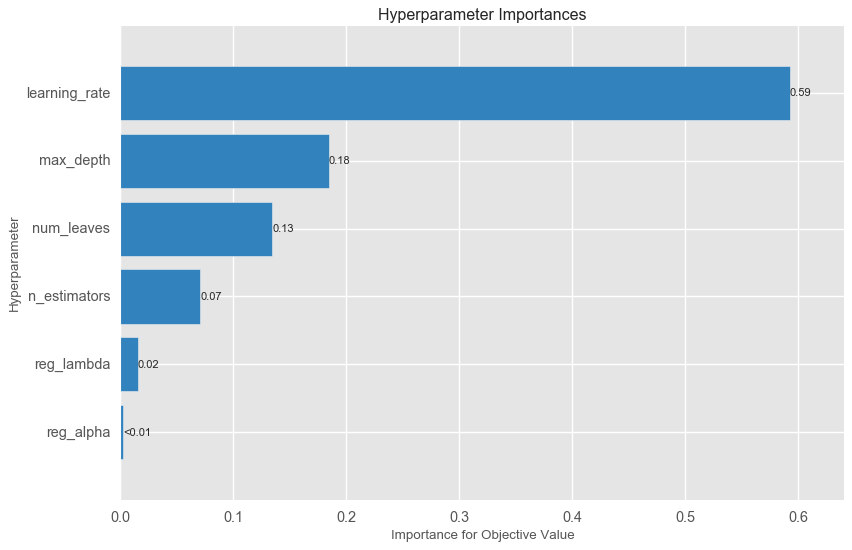

In [ ]:
plt.style.use('tableau-colorblind10')
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()  # график, от каких параметров больше всего зависит качество модели

Text(0, 0.5, 'mean importance')

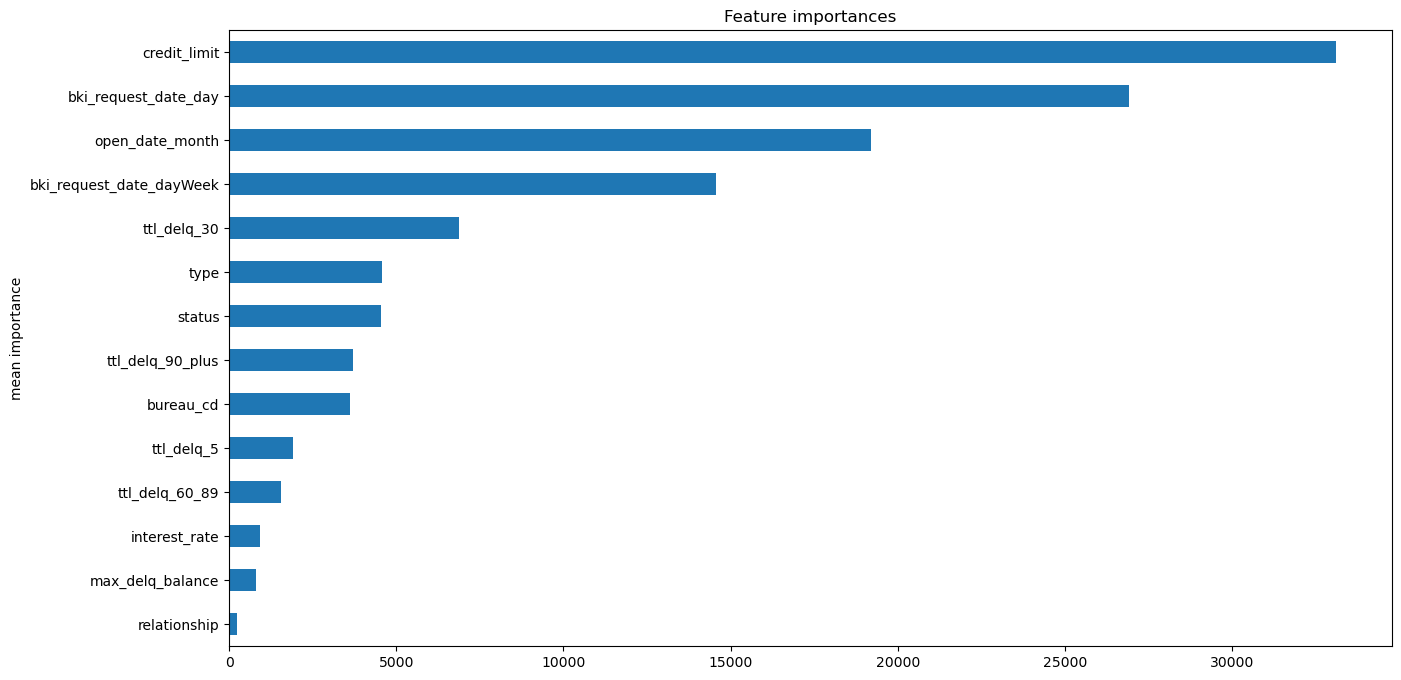

In [62]:
# plt.style.use('tableau-colorblind10')
importances_lgbm = model.feature_importances_
lgbm_importances = pd.Series(
    importances_lgbm, index=x_train.columns).sort_values(0, ascending=True)[:25]

fig, ax = plt.subplots(figsize=(15, 8))
lgbm_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importance')

In [63]:
feat_imp = pd.DataFrame(lgbm_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(
    param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
credit_limit,33117,Кредитный лимит. Сумма в рублях по курсу ЦБ РФ
bki_request_date_day,26926,"день, в который был сделан запрос в бюро"
open_date_month,19212,месяц открытия договора
bki_request_date_dayWeek,14559,"день недели, в который был сделан запрос в бюро"
ttl_delq_30,6879,Количество просрочек до 30 дней
type,4559,Код типа договора
status,4554,Статус договора
ttl_delq_90_plus,3719,Количество просрочек 90+ дней
bureau_cd,3606,"Код бюро, из которого получен счет"
ttl_delq_5,1902,Количество просрочек до 5 дней


In [ ]:
# получились тоже высокие результаты, как и у RandomForestClassifier
# AUC на тесте примерно такой же - 0.97039

## 3.5 XGBClassifier

In [64]:
pipe_xgb_cls = Pipeline(steps=[('scaler', MinMaxScaler()),
                               ('model', XGBClassifier(tree_method='gpu_hist',
                                                       objective='binary:logistic',
                                                       learning_rate=0.5,
                                                       n_estimators=50,
                                                       reg_lambda=25,
                                                       max_depth=30))])

pipe_xgb_cls.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=30, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [65]:
get_report(pipe=pipe_xgb_cls, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({1: 36504, 0: 36503})
predictions -  Counter({0: 39908, 1: 33099})

roc_auc_score - 0.9728
Gini -  0.9455

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     36503
           1       0.98      0.89      0.93     36504

    accuracy                           0.94     73007
   macro avg       0.94      0.94      0.94     73007
weighted avg       0.94      0.94      0.94     73007




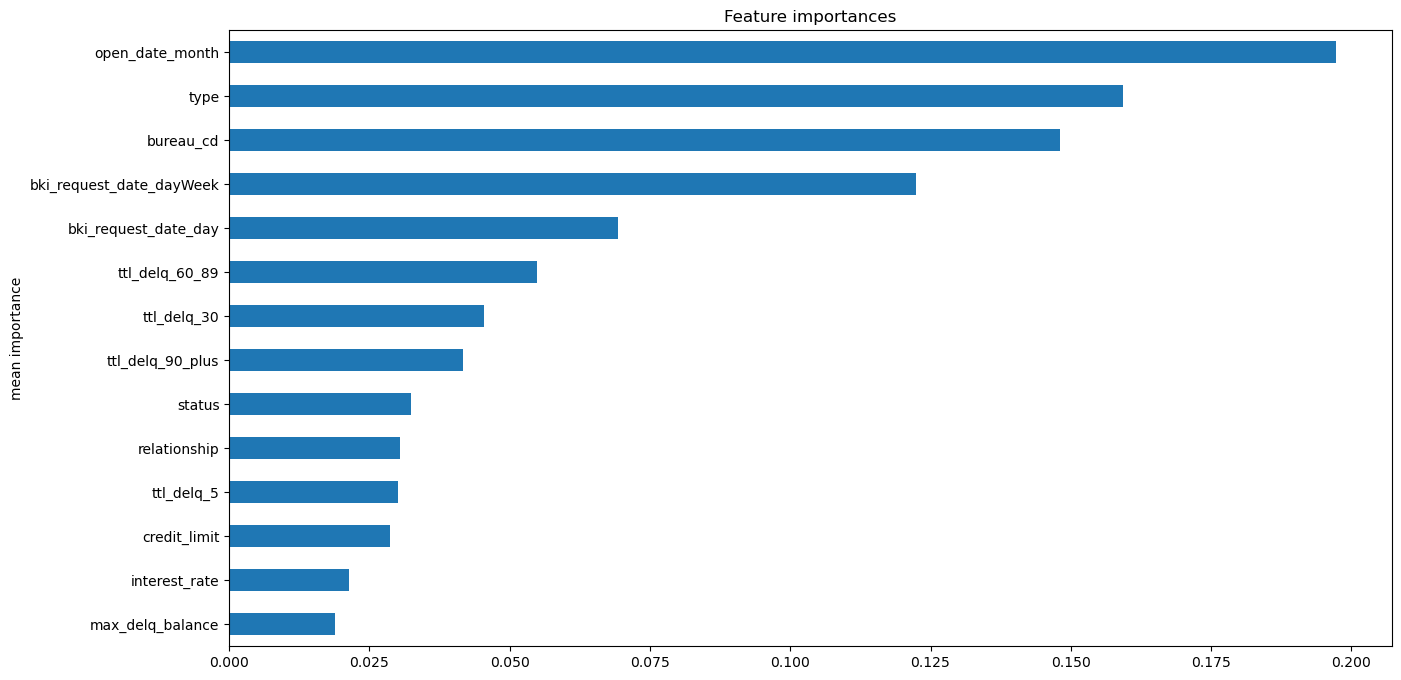

In [66]:
importances = pipe_xgb_cls[-1].feature_importances_

xgb_importances = pd.Series(
    importances, index=x_train.columns).sort_values(0, ascending=True)

# plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(figsize=(15, 8))
xgb_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importance')
plt.show()

In [67]:
feat_imp = pd.DataFrame(xgb_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(
    param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
open_date_month,0.197314,месяц открытия договора
type,0.159297,Код типа договора
bureau_cd,0.148140,"Код бюро, из которого получен счет"
bki_request_date_dayWeek,0.122457,"день недели, в который был сделан запрос в бюро"
bki_request_date_day,0.069233,"день, в который был сделан запрос в бюро"
ttl_delq_60_89,0.054903,Количество просрочек от 60 до 89 дней
ttl_delq_30,0.045413,Количество просрочек до 30 дней
ttl_delq_90_plus,0.041595,Количество просрочек 90+ дней
status,0.032339,Статус договора
relationship,0.030432,Тип отношения к договору


In [173]:
cv_xgb_cls = cross_val_predict(pipe_xgb_cls,
                               cv=StratifiedKFold(n_splits=5, shuffle=True),
                               X=x_test,
                               y=y_test,
                               verbose=10,
                               n_jobs=-1,
                               method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.1s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.1s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


In [174]:
print(f'auc score = {roc_auc_score(y_test, cv_xgb_cls[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_test, cv_xgb_cls[:, 1]) - 1) :.5f}')

auc score = 0.95888
Gini      = 0.91776


In [ ]:
# Аналогично RandomForestClassifier и LGBMClassifier - AUC=0.9728
# проверка через кросс-валидацию уменьшило AUC до 0.95888

## 3.6 CatBoost

In [68]:
from catboost import CatBoostClassifier, cv, Pool, MetricVisualizer
from catboost.utils import select_threshold, get_roc_curve, get_fpr_curve, get_fnr_curve
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures

In [69]:
model_catboost_cls = CatBoostClassifier(
    loss_function='Logloss', custom_loss='AUC', eval_metric='AUC',
    learning_rate=0.01, iterations=3500,
    l2_leaf_reg=10, random_strength=101, depth=8,
)

m = model_catboost_cls.fit(x_train, y_train, eval_set=(x_test, y_test),
                           verbose=500, plot=True, early_stopping_rounds=200)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5740346	best: 0.5740346 (0)	total: 181ms	remaining: 10m 32s
500:	test: 0.8053591	best: 0.8054256 (499)	total: 14s	remaining: 1m 23s
1000:	test: 0.8379726	best: 0.8379726 (1000)	total: 27.8s	remaining: 1m 9s
1500:	test: 0.9000069	best: 0.9000069 (1500)	total: 42.1s	remaining: 56.1s
2000:	test: 0.9494474	best: 0.9494474 (2000)	total: 57.1s	remaining: 42.8s
2500:	test: 0.9537863	best: 0.9537863 (2500)	total: 1m 12s	remaining: 28.9s
3000:	test: 0.9555929	best: 0.9555929 (3000)	total: 1m 27s	remaining: 14.6s
3499:	test: 0.9568817	best: 0.9568817 (3499)	total: 1m 42s	remaining: 0us

bestTest = 0.956881656
bestIteration = 3499



In [70]:
print(
    f'auc score TEST  = {roc_auc_score(y_val, model_catboost_cls.predict_proba(x_val)[:, 1]):.5f}')
print(
    f'Gini TEST       = { (2 * roc_auc_score(y_val, model_catboost_cls.predict_proba(x_val)[:, 1]) - 1) :.5f}')

# test выборка учавствует в обучении, поэтому проверяем результаты на val-выборке
# результат финальный, такой же будет в пункте 4.1

auc score TEST  = 0.95662
Gini TEST       = 0.91324


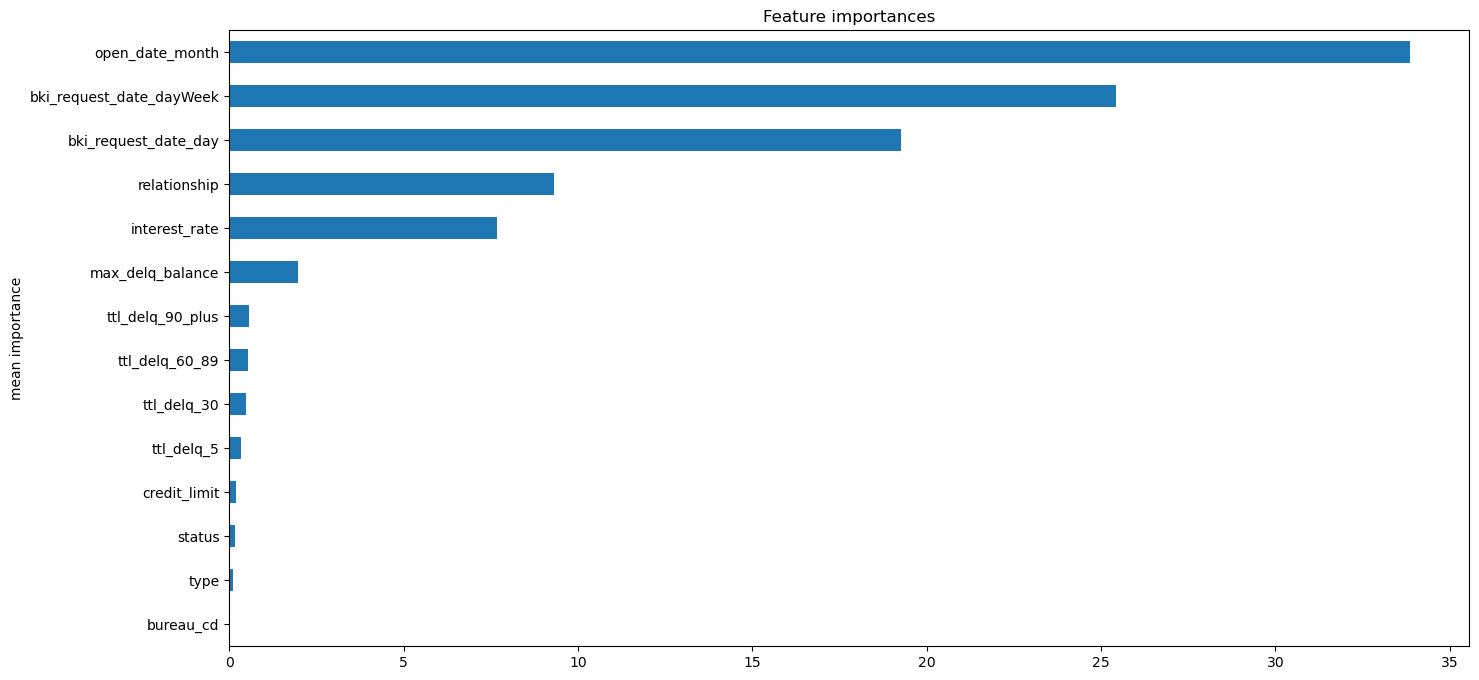

In [72]:
# plt.style.use('tableau-colorblind10')
cat_features = pd.DataFrame(model_catboost_cls.get_feature_importance(prettified=True)) \
    .sort_values('Importances', ascending=True)

skl_iris_imp = pd.Series(cat_features.Importances.values,
                         x_train.columns)

fig, ax = plt.subplots(figsize=(16, 8))
skl_iris_imp.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importance')
plt.show()

In [73]:
feat_imp = pd.DataFrame(skl_iris_imp).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(
    param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
open_date_month,33.859316,месяц открытия договора
bki_request_date_dayWeek,25.438187,"день недели, в который был сделан запрос в бюро"
bki_request_date_day,19.271697,"день, в который был сделан запрос в бюро"
relationship,9.324288,Тип отношения к договору
interest_rate,7.678067,Процентная ставка по кредиту
max_delq_balance,1.973477,Максимальный объем просроченной задолженности....
ttl_delq_90_plus,0.579649,Количество просрочек 90+ дней
ttl_delq_60_89,0.541764,Количество просрочек от 60 до 89 дней
ttl_delq_30,0.487675,Количество просрочек до 30 дней
ttl_delq_5,0.340032,Количество просрочек до 5 дней


In [ ]:
# модель, как и остальные бустинги, показывает хорошее качетсво
# есть небольшое недообучение, но если смотреть по графику AUC - качество достигло максимума - 0.95189
# на val-выборке = 0.95662

## 3.7 NN

In [12]:
model = Sequential()

model.add(Dense(units=5000, input_shape=(
    x_train.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(Dense(500, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(100, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

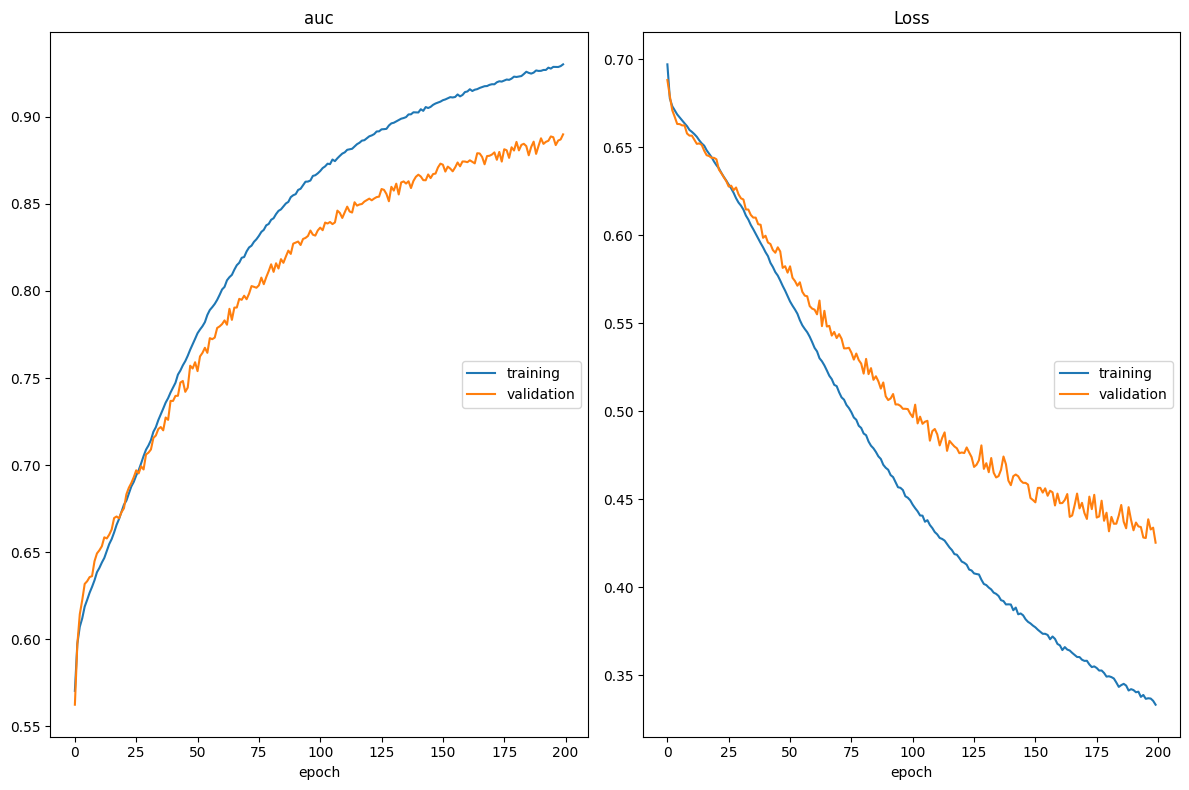

auc
	training         	 (min:    0.570, max:    0.930, cur:    0.930)
	validation       	 (min:    0.562, max:    0.890, cur:    0.890)
Loss
	training         	 (min:    0.333, max:    0.697, cur:    0.333)
	validation       	 (min:    0.425, max:    0.688, cur:    0.425)
179/179 [==============================] - 5s 26ms/step - loss: 0.3334 - auc: 0.9301 - val_loss: 0.4254 - val_auc: 0.8899



In [13]:
cp = ModelCheckpoint('model/', save_best_only=True)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=[keras.metrics.AUC()]
              )

history = model.fit(x_train,
                    y_train,
                    validation_split=0.25,
                    batch_size=1024,
                    epochs=200,
                    verbose=1,
                    callbacks=[cp, PlotLossesKeras(), callback])


print('\n ==============')

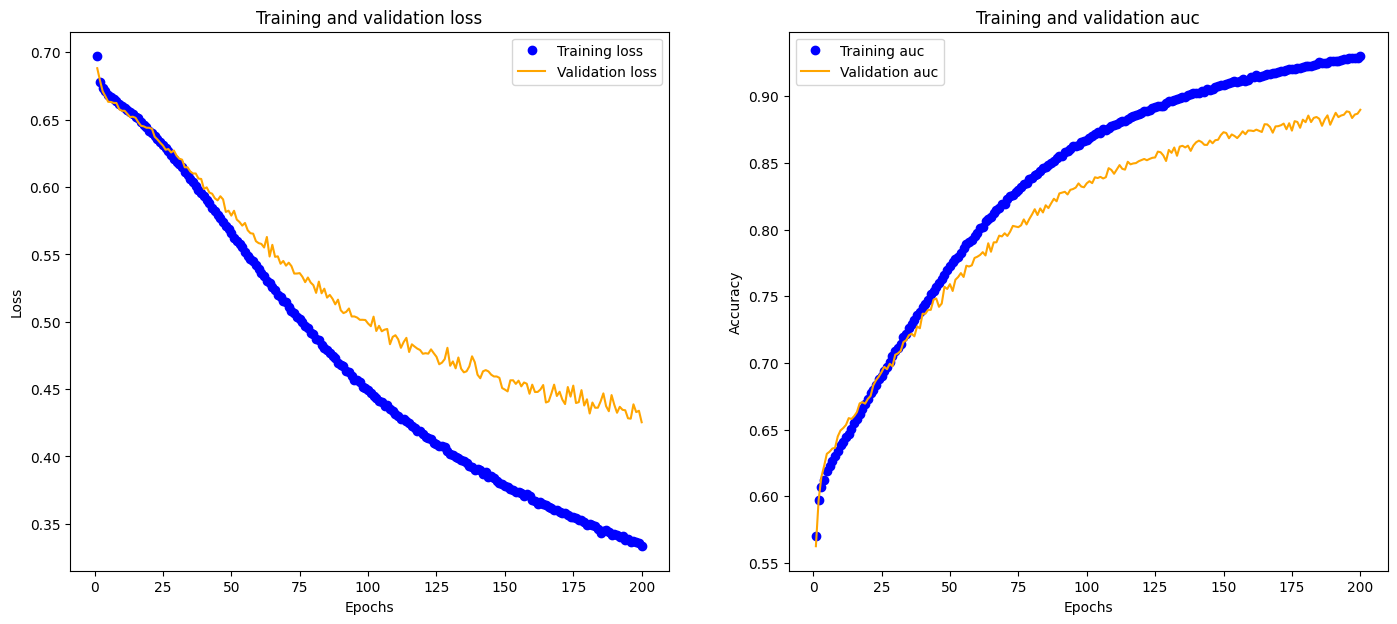


Best auc score: 0.8898700475692749


In [14]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc = history.history[list(history.history.keys())[1]]
val_acc = history.history[list(history.history.keys())[3]]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'orange', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print()
print(f'Best auc score: {np.max(val_acc)}')

plt.show()

In [20]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, auc, roc_curve

model = load_model('model/')

predictions = model.predict(x_val, batch_size=128)
predictions = np.round(predictions.ravel(), 0)

print()
print('auc(fpr, tpr)', auc(roc_curve(y_val, predictions)
      [0], roc_curve(y_val, predictions)[1]))
print()
print(classification_report(y_val, predictions))

64/64 [==============================] - 0s 2ms/step

auc(fpr, tpr) 0.802736534387867

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      4055
           1       0.80      0.81      0.80      4056

    accuracy                           0.80      8111
   macro avg       0.80      0.80      0.80      8111
weighted avg       0.80      0.80      0.80      8111



In [ ]:
# лучший AUC при обучении получился 0.889 (valid-выборка, взята из train-выборки)

# на x_val AUC=0.803 - лучше, чем у LogisticRegression

# 4. Результаты

## 4.1 Таблица результатов

In [184]:
da = [
    ['LogisticRegression',
     roc_auc_score(y_val, pipe_logreg.predict_proba(x_val)[:, 1]),
     2 * roc_auc_score(y_val, pipe_logreg.predict_proba(x_val)[:, 1])-1,
     precision_recall_fscore_support(y_val, np.round(
         pipe_logreg.predict(x_val), 0), average='weighted')[0],
     precision_recall_fscore_support(y_val, np.round(
         pipe_logreg.predict(x_val), 0), average='weighted')[1],
     precision_recall_fscore_support(y_val, np.round(pipe_logreg.predict(x_val), 0), average='weighted')[2]],

    ['LinearRegression',
     roc_auc_score(y_val, pipe_linreg.predict(x_val)),
     2 * roc_auc_score(y_val, pipe_linreg.predict(x_val))-1,
     precision_recall_fscore_support(y_val, np.round(
         pipe_linreg.predict(x_val), 0), average='weighted')[0],
     precision_recall_fscore_support(y_val, np.round(
         pipe_linreg.predict(x_val), 0), average='weighted')[1],
     precision_recall_fscore_support(y_val, np.round(pipe_linreg.predict(x_val), 0), average='weighted')[2]],

    ['RandomForestClassifier',
     roc_auc_score(y_val, pipe_rforest.predict_proba(x_val)[:, 1]),
     2 * roc_auc_score(y_val, pipe_rforest.predict_proba(x_val)[:, 1])-1,
     precision_recall_fscore_support(y_val, np.round(
         pipe_rforest.predict(x_val), 0), average='weighted')[0],
     precision_recall_fscore_support(y_val, np.round(
         pipe_rforest.predict(x_val), 0), average='weighted')[1],
     precision_recall_fscore_support(y_val, np.round(pipe_rforest.predict(x_val), 0), average='weighted')[2]],

    ['LGBMClassifier',
     roc_auc_score(y_val, model.predict_proba(x_val)[:, 1]),
     2 * roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])-1,
     precision_recall_fscore_support(y_val, np.round(
         model.predict(x_val), 0), average='weighted')[0],
     precision_recall_fscore_support(y_val, np.round(
         model.predict(x_val), 0), average='weighted')[1],
     precision_recall_fscore_support(y_val, np.round(model.predict(x_val), 0), average='weighted')[2]],

    ['XGBClassifier',
     roc_auc_score(y_val, pipe_xgb_cls.predict_proba(x_val)[:, 1]),
     2 * roc_auc_score(y_val, pipe_xgb_cls.predict_proba(x_val)[:, 1])-1,
     precision_recall_fscore_support(y_val, np.round(
         pipe_xgb_cls.predict(x_val), 0), average='weighted')[0],
     precision_recall_fscore_support(y_val, np.round(
         pipe_xgb_cls.predict(x_val), 0), average='weighted')[1],
     precision_recall_fscore_support(y_val, np.round(pipe_xgb_cls.predict(x_val), 0), average='weighted')[2]],

    ['CatBoostClassifier',
     roc_auc_score(y_val, model_catboost_cls.predict_proba(x_val)[:, 1]),
     2 * roc_auc_score(y_val,model_catboost_cls.predict_proba(x_val)[:, 1])-1,
     precision_recall_fscore_support(y_val, np.round(
         model_catboost_cls.predict(x_val), 0), average='weighted')[0],
     precision_recall_fscore_support(y_val, np.round(
         model_catboost_cls.predict(x_val), 0), average='weighted')[1],
     precision_recall_fscore_support(y_val, np.round(model_catboost_cls.predict(x_val), 0), average='weighted')[2]],

    ['NN',
     0.8027,
     2 * 0.8027 - 1,
     0.80,
     0.80,
     0.80],

    ['AutoML',
     roc_auc_score(y_val.values, preds_val.data[:, 0]),
     2 * roc_auc_score(y_val.values, preds_val.data[:, 0]) - 1,
     precision_recall_fscore_support(y_val, np.round(
         automl.predict(x_val).data[:, 0], 0), average='weighted')[0],
     precision_recall_fscore_support(y_val, np.round(
         automl.predict(x_val).data[:, 0], 0), average='weighted')[1],
     precision_recall_fscore_support(y_val, np.round(automl.predict(x_val).data[:, 0], 0), average='weighted')[2]],
]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_job

In [33]:
result = pd.DataFrame(da, columns=[
                      'Model', 'AUC', 'GINI', 'PRECISION', 'RECALL', 'FSCORE']).set_index('Model')

result.sort_values(by='GINI', ascending=False) \
    .style.background_gradient(cmap=sns.light_palette('darkblue', as_cmap=True), vmin=0.81)

,AUC,GINI,PRECISION,RECALL,FSCORE
Model,,,,,
RandomForestClassifier,0.972645,0.945291,0.930380,0.928501,0.928423
AutoML,0.972008,0.944016,0.945954,0.942083,0.941957
XGBClassifier,0.971524,0.943048,0.938243,0.934295,0.934147
LGBMClassifier,0.971474,0.942948,0.944075,0.938363,0.938164
CatBoostClassifier,0.956620,0.913240,0.939662,0.931460,0.931138
NN,0.802700,0.605400,0.800000,0.800000,0.800000
LogisticRegression,0.576800,0.153600,0.557851,0.557569,0.557030
LinearRegression,0.541849,0.083698,0.526725,0.525025,0.517349


> Лучше всего показала себя модель **RandomForestClassifier**, но остальные бустинги примерно схожи 

> Также, LightAutoMl обучилась хорошо. Сама LightAutoMl состоит из двух LGBMClassifier-моделей

> У моделей RandomForestClassifier, LGBMClassifier и XGBClassifier показывают одинаковые результаты - 0.95-0.95

NN и LogisticRegression схожи по AUC

## 4.2 Выбор оптимального порога для лучшей модели - RandomForestClassifier

In [121]:
pred = pipe_rforest.predict_proba(x_val)[:, 1]

# создадим таблицу, чтобы увидеть как модель прогнозирует таргет
pdD = pd.DataFrame({'pred': pred, 'y_val': y_val})
pdD.head()

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


,pred,y_val
322130,0.96,1
240329,0.98,1
179094,0.09,0
188034,0.97,1
247704,0.98,1


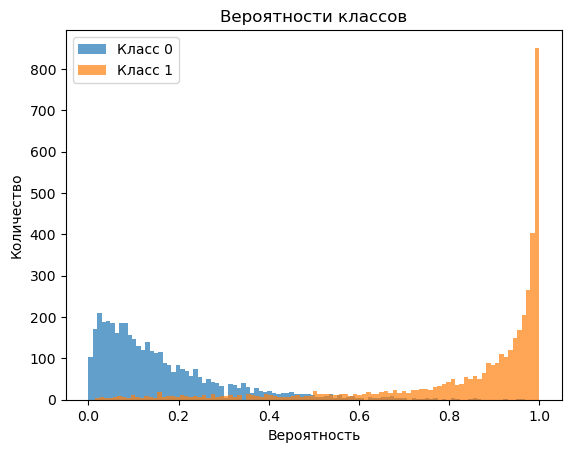

In [128]:
plt.hist(pdD[pdD['y_val'] == 0].pred, bins=100, alpha=0.7, label='Класс 0')
plt.hist(pdD[pdD['y_val'] == 1].pred, bins=100, alpha=0.7, label='Класс 1')
plt.title('Вероятности классов')
plt.xlabel('Вероятность')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [129]:
get_report(pipe=pipe_rforest, x_test=x_val, y_test=y_val)
print()

y_test -  Counter({1: 4056, 0: 4056})
predictions -  Counter({0: 4324, 1: 3788})

roc_auc_score - 0.9726
Gini -  0.9453

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      4056
           1       0.96      0.90      0.93      4056

    accuracy                           0.93      8112
   macro avg       0.93      0.93      0.93      8112
weighted avg       0.93      0.93      0.93      8112




[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [131]:
predictions_proba = pipe_rforest.predict_proba(x_val)[:, 1]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


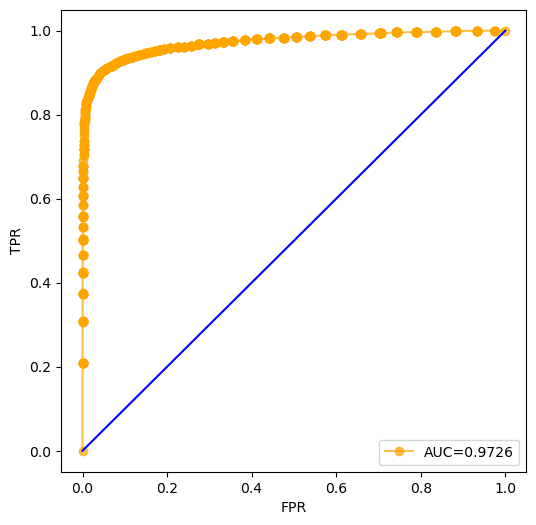

In [144]:
from sklearn.metrics import roc_curve

y_pred = pipe_rforest.predict_proba(x_val)[:, 1]
fpr, tpr, threshhold = roc_curve(y_val, y_pred, drop_intermediate=False)
auc = round(roc_auc_score(y_val, y_pred), 4)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='AUC=' + str(auc),
         color='orange', marker='o', alpha=0.7)
plt.plot([1, 0], [1, 0], color='blue')
plt.legend(loc='lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

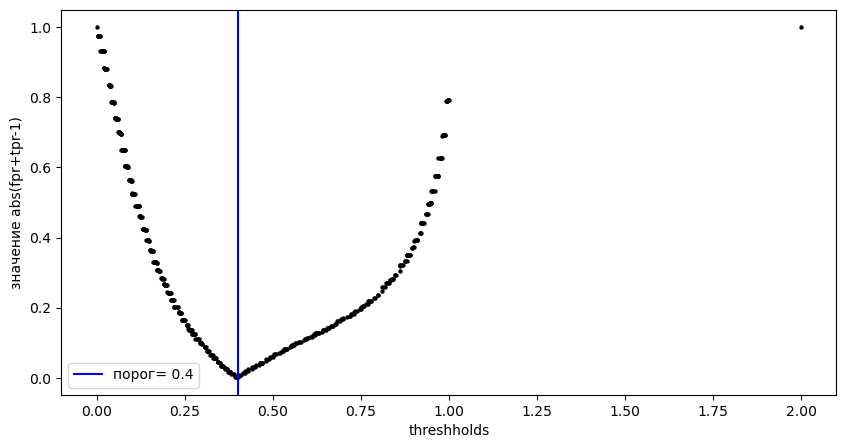

Optimal threshhold: 0.4


In [143]:
plt.figure(figsize=(10, 5))
plt.scatter(x=threshhold, y=abs(fpr+tpr-1), s=10, c='black', linewidth=0)
plt.axvline(threshhold[np.argmin(np.abs(fpr+tpr-1))],
            color='blue',
            label=f'порог= {threshhold[np.argmin(np.abs(fpr+tpr-1))]}')

plt.ylabel('значение abs(fpr+tpr-1)')
plt.xlabel('threshholds')
plt.legend()
plt.show()

print('Optimal threshhold:', threshhold[np.argmin(np.abs(fpr+tpr-1))])

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_y_pred = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_val, cm_y_pred, labels=[0, 1])

# confusion_matrix со стандартным порогом 0.5
cm

array([[3900,  156],
       [ 424, 3632]], dtype=int64)

In [137]:
cm_y_pred = np.where(y_pred > 0.4, 1, 0)

cm = confusion_matrix(y_val, cm_y_pred, labels=[0, 1])

# confusion_matrix with threshhold=0.4
# при пороге в 0.4 достигается оптимальное решение для FN и FP
cm

array([[3755,  301],
       [ 326, 3730]], dtype=int64)

## 4.3 Выводы

**Способы улучшения моделей:**

*Способы именно для этого датасета

> В целом, не было сильной разницы в метриках после использования optuna: RandomForestClassifier с базовыми параметрами обучается так же, как и LGBMClassifier + optuna

> Линейная и логистическая регрессии должны улавливать линейную зависимость с таргетом для высоких результатов. Для этого надо или выбирать только такие признаки, или создавать новые из имеющихся. Использовать PolynomialFeatures можно, но не подойдет для других моделей 

> Стоит отметить методы undersampling и oversampling для балансировки классов. В прошлом датасете было много строк, там логично было бы использовать undersampling, но падало качество. Для этого датасета использовался oversampling: 193_000 строк -> 324_000 строк, баланс классов с 1 к 10 изменился до 1 к 1 (количество заемщиков, которые в дефолте равно заемщикам не в дефолте)

> Добавление новых признаков. Для датасета добавились день, месяц и день недели для признаков bki_request_date, open_date, inf_confirm_date. На графиках важности признаков видно, что они тоже влияют на результат

> Очистка данных. Например, в столбце процентной ставки много значений 0%. Удалять их - терять данные,
заполнять средним или медианой - у каждого клиета разные кредиты.